# Handwriting generation
This notebook implements section 5 of Alex Graves paper "Generating Sequences With Recurrent Neural Networks".

## Loading the data
First step is to load the data. The code was modified from https://nbviewer.jupyter.org/github/greydanus/scribe/blob/master/dataloader.ipynb. Big thanks to his author !

In [1]:
import os
import pickle
import random
import xml.etree.ElementTree as ET

import numpy as np
import svgwrite
from IPython.display import SVG, display
import matplotlib.cm as cm

import torch
from torch import nn, optim
import torch.nn.functional as F
use_cuda = False
use_cuda = torch.cuda.is_available()

import time
import matplotlib.pyplot as plt
%matplotlib inline

from ipywidgets import FloatProgress

n_batch = 20
sequence_length = 400
U_items = int(sequence_length/25)

hidden_size = 256
n_layers = 3
n_gaussians = 20
Kmixtures = 10

eps = float(np.finfo(np.float32).eps)

# Hyperparameters
gradient_threshold = 10
dropout = 0.2



torch.cuda.empty_cache()

In [2]:
def get_bounds(data, factor):
    min_x = 0
    max_x = 0
    min_y = 0
    max_y = 0

    abs_x = 0
    abs_y = 0
    for i in range(len(data)):
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        abs_x += x
        abs_y += y
        min_x = min(min_x, abs_x)
        min_y = min(min_y, abs_y)
        max_x = max(max_x, abs_x)
        max_y = max(max_y, abs_y)

    return (min_x, max_x, min_y, max_y)

# old version, where each path is entire stroke (smaller svg size, but
# have to keep same color)


def draw_strokes(data, factor=10, svg_filename='sample.svg'):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1

    abs_x = 25 - min_x
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)

    command = "m"

    for i in range(len(data)):
        if (lift_pen == 1):
            command = "m"
        elif (command != "l"):
            command = "l"
        else:
            command = ""
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        lift_pen = data[i, 2]
        p += command + str(x) + "," + str(y) + " "

    the_color = "black"
    stroke_width = 1

    dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill("none"))

    dwg.save()
    display(SVG(dwg.tostring()))


def draw_strokes_eos_weighted(
        stroke,
        param,
        factor=10,
        svg_filename='sample_eos.svg'):
    c_data_eos = np.zeros((len(stroke), 3))
    for i in range(len(param)):
        # make color gray scale, darker = more likely to eos
        c_data_eos[i, :] = (1 - param[i][6][0]) * 225
    draw_strokes_custom_color(
        stroke,
        factor=factor,
        svg_filename=svg_filename,
        color_data=c_data_eos,
        stroke_width=3)


def draw_strokes_random_color(
        stroke,
        factor=10,
        svg_filename='sample_random_color.svg',
        per_stroke_mode=True):
    c_data = np.array(np.random.rand(len(stroke), 3) * 240, dtype=np.uint8)
    if per_stroke_mode:
        switch_color = False
        for i in range(len(stroke)):
            if switch_color == False and i > 0:
                c_data[i] = c_data[i - 1]
            if stroke[i, 2] < 1:  # same strike
                switch_color = False
            else:
                switch_color = True
    draw_strokes_custom_color(
        stroke,
        factor=factor,
        svg_filename=svg_filename,
        color_data=c_data,
        stroke_width=2)


def draw_strokes_custom_color(
        data,
        factor=10,
        svg_filename='test.svg',
        color_data=None,
        stroke_width=1):
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)

    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))

    lift_pen = 1
    abs_x = 25 - min_x
    abs_y = 25 - min_y

    for i in range(len(data)):

        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor

        prev_x = abs_x
        prev_y = abs_y

        abs_x += x
        abs_y += y

        if (lift_pen == 1):
            p = "M " + str(abs_x) + "," + str(abs_y) + " "
        else:
            p = "M +" + str(prev_x) + "," + str(prev_y) + \
                " L " + str(abs_x) + "," + str(abs_y) + " "

        lift_pen = data[i, 2]

        the_color = "black"

        if (color_data is not None):
            the_color = "rgb(" + str(int(color_data[i, 0])) + "," + str(
                int(color_data[i, 1])) + "," + str(int(color_data[i, 2])) + ")"

        dwg.add(dwg.path(p).stroke(the_color, stroke_width).fill(the_color))
    dwg.save()
    display(SVG(dwg.tostring()))

        
class DataLoader():
    def __init__(self, batch_size=50, tsteps=300, scale_factor = 10, U_items=10, limit = 500, alphabet="default"):
        self.data_dir = "./data"
        self.alphabet = alphabet
        self.batch_size = batch_size
        self.tsteps = tsteps
        self.scale_factor = scale_factor # divide data by this factor
        self.limit = limit # removes large noisy gaps in the data
        self.U_items = U_items

        data_file = os.path.join(self.data_dir, "strokes_training_data_generation.cpkl")
        stroke_dir = self.data_dir+"/lineStrokes"
        ascii_dir = self.data_dir+"/ascii"

        if not (os.path.exists(data_file)) :
            print ("creating training data cpkl file from raw source")
            self.preprocess(stroke_dir, ascii_dir, data_file)

        self.load_preprocessed(data_file)
        self.reset_batch_pointer()

    def preprocess(self, stroke_dir, ascii_dir, data_file):
        # create data file from raw xml files from iam handwriting source.
        print ("Parsing dataset...")
        
        # build the list of xml files
        filelist = []
        # Set the directory you want to start from
        rootDir = stroke_dir
        for dirName, subdirList, fileList in os.walk(rootDir):
#             print('Found directory: %s' % dirName)
            for fname in fileList:
#                 print('\t%s' % fname)
                filelist.append(dirName+"/"+fname)

        # function to read each individual xml file
        def getStrokes(filename):
            tree = ET.parse(filename)
            root = tree.getroot()

            result = []

            x_offset = 1e20
            y_offset = 1e20
            y_height = 0
            for i in range(1, 4):
                x_offset = min(x_offset, float(root[0][i].attrib['x']))
                y_offset = min(y_offset, float(root[0][i].attrib['y']))
                y_height = max(y_height, float(root[0][i].attrib['y']))
            y_height -= y_offset
            x_offset -= 100
            y_offset -= 100

            for stroke in root[1].findall('Stroke'):
                points = []
                for point in stroke.findall('Point'):
                    points.append([float(point.attrib['x'])-x_offset,float(point.attrib['y'])-y_offset])
                result.append(points)
            return result
        
        # function to read each individual xml file
        def getAscii(filename, line_number):
            with open(filename, "r") as f:
                s = f.read()
            s = s[s.find("CSR"):]
            if len(s.split("\n")) > line_number+2:
                s = s.split("\n")[line_number+2]
                return s
            else:
                return ""
                
        # converts a list of arrays into a 2d numpy int16 array
        def convert_stroke_to_array(stroke):
            n_point = 0
            for i in range(len(stroke)):
                n_point += len(stroke[i])
            stroke_data = np.zeros((n_point, 3), dtype=np.int16)

            prev_x = 0
            prev_y = 0
            counter = 0

            for j in range(len(stroke)):
                for k in range(len(stroke[j])):
                    stroke_data[counter, 0] = int(stroke[j][k][0]) - prev_x
                    stroke_data[counter, 1] = int(stroke[j][k][1]) - prev_y
                    prev_x = int(stroke[j][k][0])
                    prev_y = int(stroke[j][k][1])
                    stroke_data[counter, 2] = 0
                    if (k == (len(stroke[j])-1)): # end of stroke
                        stroke_data[counter, 2] = 1
                    counter += 1
            return stroke_data

        # build stroke database of every xml file inside iam database
        strokes = []
        asciis = []
        for i in range(len(filelist)):
            if (filelist[i][-3:] == 'xml'):
                stroke_file = filelist[i]
#                 print 'processing '+stroke_file
                stroke = convert_stroke_to_array(getStrokes(stroke_file))
                
                ascii_file = stroke_file.replace("lineStrokes","ascii")[:-7] + ".txt"
                line_number = stroke_file[-6:-4]
                line_number = int(line_number) - 1
                ascii = getAscii(ascii_file, line_number)
                if len(ascii) > 10:
                    strokes.append(stroke)
                    asciis.append(ascii)
                else:
                    print ("======>>>> Line length was too short. Line was: " + ascii)
                
        assert(len(strokes)==len(asciis)), "There should be a 1:1 correspondence between stroke data and ascii labels."
        f = open(data_file,"wb")
        pickle.dump([strokes,asciis], f, protocol=2)
        f.close()
        print ("Finished parsing dataset. Saved {} lines".format(len(strokes)))


    def load_preprocessed(self, data_file):
        f = open(data_file,"rb")
        [self.raw_stroke_data, self.raw_ascii_data] = pickle.load(f)
        f.close()

        # goes thru the list, and only keeps the text entries that have more than tsteps points
        self.stroke_data = []
        self.ascii_data = []
        counter = 0

        for i in range(len(self.raw_stroke_data)):
            data = self.raw_stroke_data[i]
            if len(data) > (self.tsteps+2):
                # removes large gaps from the data
                data = np.minimum(data, self.limit)
                data = np.maximum(data, -self.limit)
                data = np.array(data,dtype=np.float32)
                data[:,0:2] /= self.scale_factor
                
                self.stroke_data.append(data)
                self.ascii_data.append(self.raw_ascii_data[i])

        # minus 1, since we want the ydata to be a shifted version of x data
        self.num_batches = int(len(self.stroke_data) / self.batch_size)
        print ("Loaded dataset:")
        print ("   -> {} individual data points".format(len(self.stroke_data)))
        print ("   -> {} batches".format(self.num_batches))

    def next_batch(self):
        # returns a randomised, tsteps sized portion of the training data
        x_batch = []
        y_batch = []
        ascii_list = []
        for i in range(self.batch_size):
            data = self.stroke_data[self.idx_perm[self.pointer]]
            x_batch.append(np.copy(data[:self.tsteps]))
            y_batch.append(np.copy(data[1:self.tsteps+1]))
            ascii_list.append(self.ascii_data[self.idx_perm[self.pointer]])
            self.tick_batch_pointer()
        one_hots = [self.one_hot(s) for s in ascii_list]
        return x_batch, y_batch, ascii_list, one_hots
    
    def one_hot(self, s):
        #index position 0 means "unknown"
        if self.alphabet is "default":
            alphabet = " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"
        seq = [alphabet.find(char) + 1 for char in s]
        if len(seq) >= self.U_items:
            seq = seq[:self.U_items]
        else:
            seq = seq + [0]*(self.U_items - len(seq))
        one_hot = np.zeros((self.U_items,len(alphabet)+1))
        one_hot[np.arange(self.U_items),seq] = 1
        return one_hot

    def tick_batch_pointer(self):
        self.pointer += 1
        if (self.pointer >= len(self.stroke_data)):
            self.reset_batch_pointer()
    def reset_batch_pointer(self):
        self.idx_perm = np.random.permutation(len(self.stroke_data))
        self.pointer = 0
        print ("pointer reset")

In [3]:
data_loader = DataLoader(n_batch, sequence_length, 20, U_items=U_items) # 20 = datascale



Loaded dataset:
   -> 10974 individual data points
   -> 548 batches
pointer reset


# Utils
line_plot : plots a sequence 

one_hot : transforms a string sequence into a one-hot matrix

plot_heatmaps : plots Phis and soft-window heatmaps

get_n_params : returns the number of parameters of a model



20


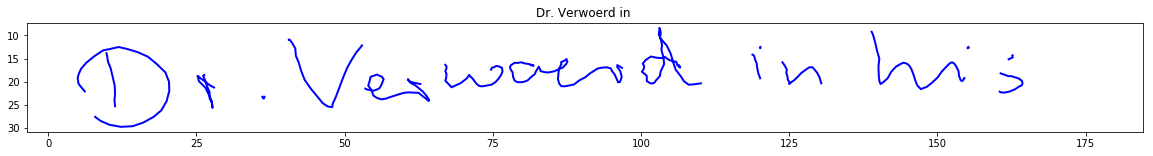

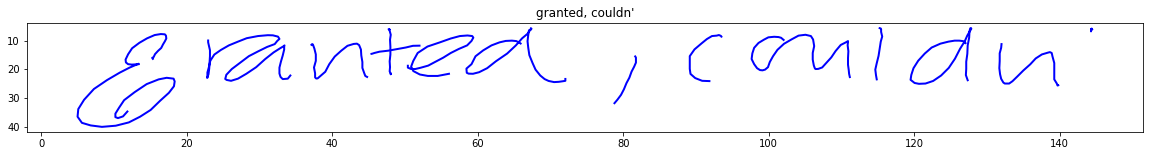

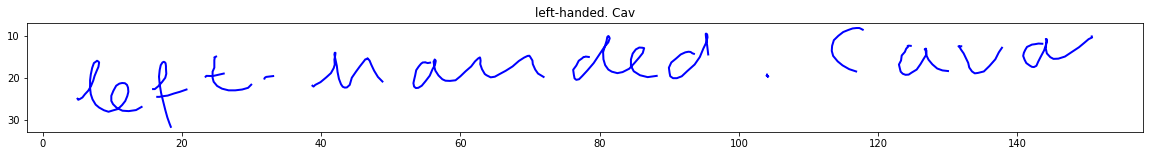

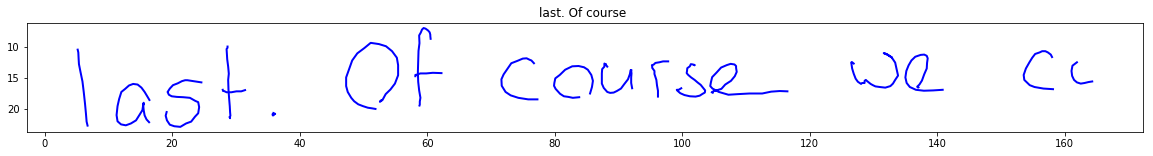

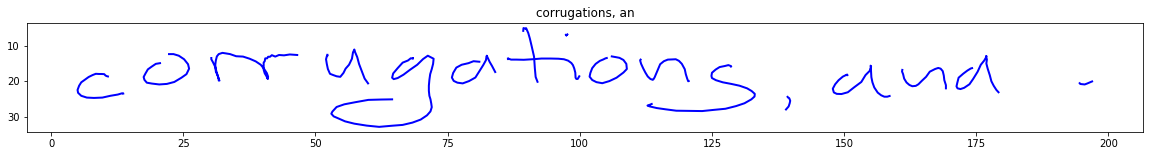

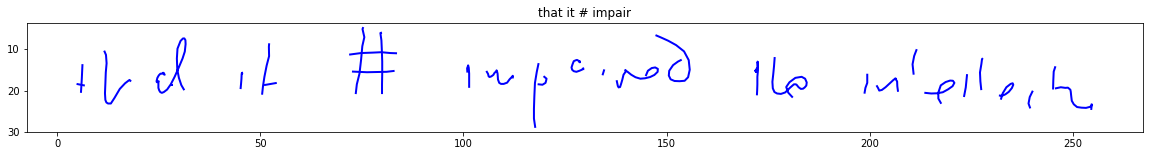

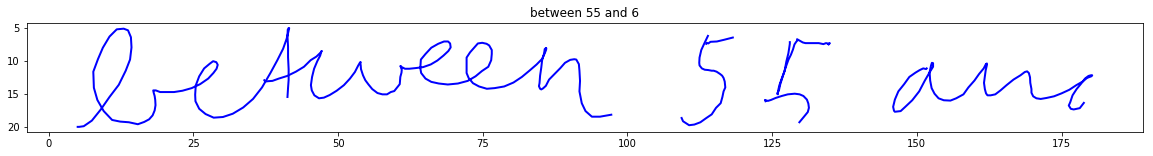

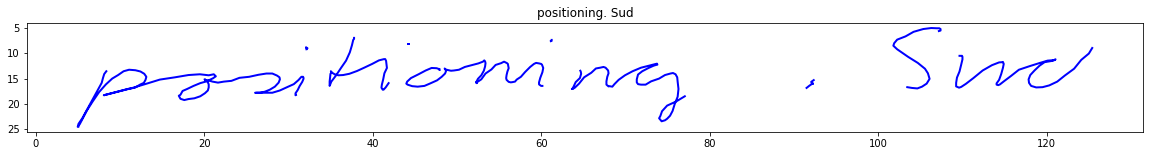

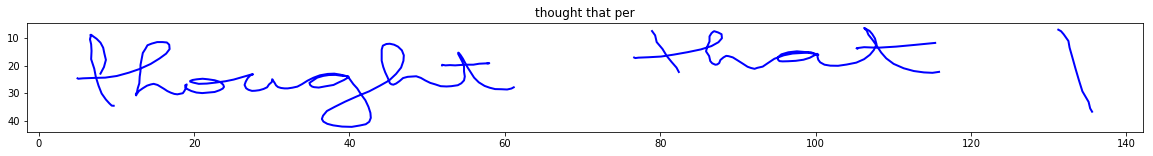

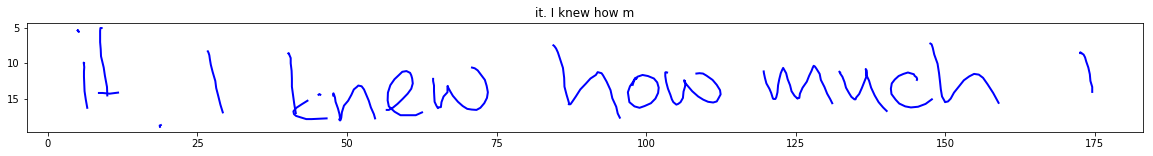

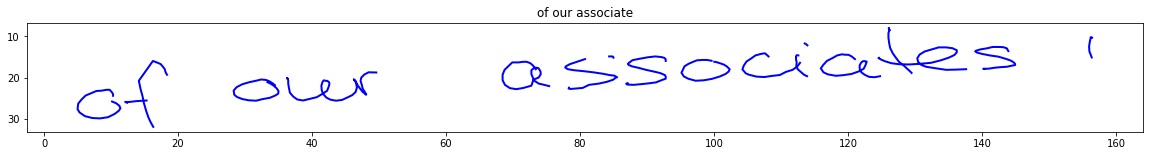

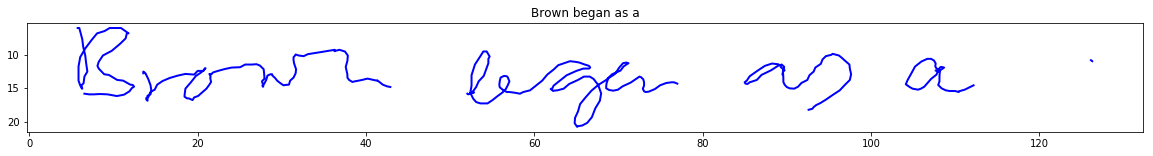

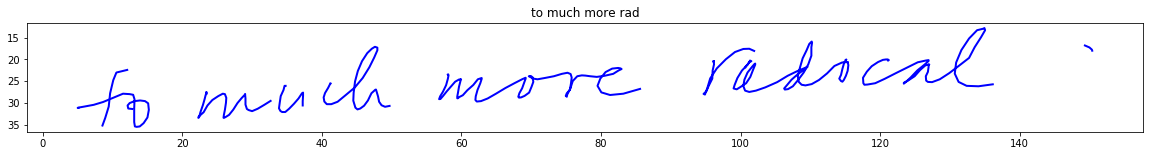

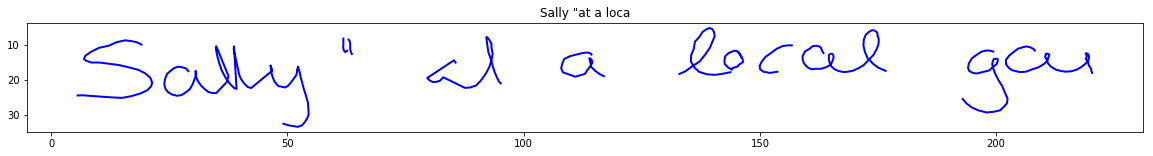

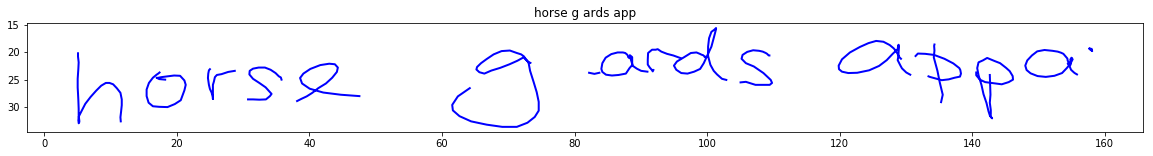

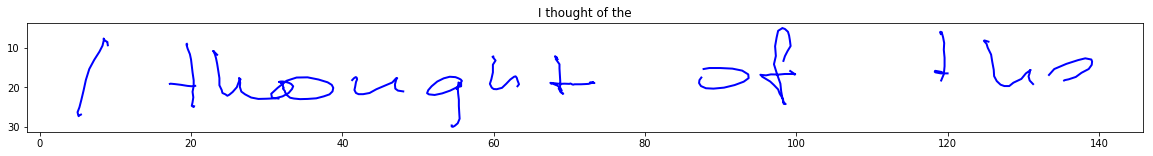

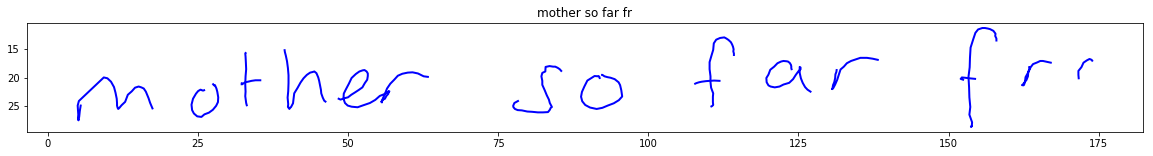

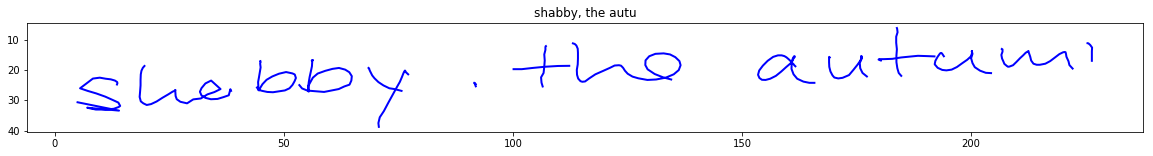

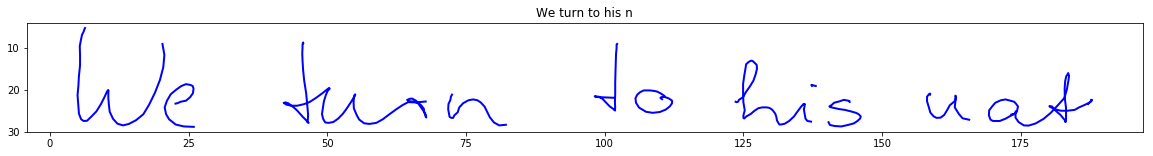

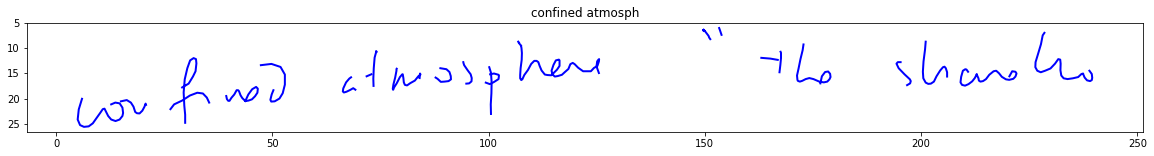

In [4]:
def line_plot(strokes, title):
    plt.figure(figsize=(20,2))
    eos_preds = np.where(strokes[:,-1] == 1)
    eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
    for i in range(len(eos_preds)-1):
        start = eos_preds[i]+1
        stop = eos_preds[i+1]
        plt.plot(strokes[start:stop,0], strokes[start:stop,1],'b-', linewidth=2.0)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

def one_hot(s):
    #index position 0 means "unknown"
    alphabet = " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890"
    seq = [alphabet.find(char) + 1 for char in s]

    one_hot = np.zeros((len(s),len(alphabet)+1))
    one_hot[np.arange(len(s)),seq] = 1
    return one_hot

def plot_heatmaps(Phis, Ws):
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.title('Phis', fontsize=20)
    plt.xlabel("time steps", fontsize=15)
    plt.ylabel("ascii #", fontsize=15)
    
    plt.imshow(Phis, interpolation='nearest', aspect='auto', cmap=cm.jet)
    plt.subplot(122)
    plt.title('Soft attention window', fontsize=20)
    plt.xlabel("time steps", fontsize=15)
    plt.ylabel("one-hot vector", fontsize=15)
    plt.imshow(Ws, interpolation='nearest', aspect='auto', cmap=cm.jet)

    display(plt.gcf())
    

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp



x, y, s, c = data_loader.next_batch()
print (data_loader.pointer)
for i in range(n_batch):
    r = x[i]
    strokes = r.copy()
    strokes[:,:-1] = np.cumsum(r[:,:-1], axis=0)
    line_plot(strokes, s[i][:U_items])
    
onehots = np.array(c) # (n_batch, U_items, len(alphabet))


# Handwriting generation with PyTorch

## Model

In [5]:
class HandwritingSynthesisModel(nn.Module):
    def __init__(self, hidden_size = 256, n_gaussians = 10, Kmixtures = 10, dropout = 0.2, alphabet_size = 64):
        super(HandwritingSynthesisModel, self).__init__()
        
        self.Kmixtures = Kmixtures
        self.n_gaussians = n_gaussians
        self.alphabet_size = alphabet_size
        
        self.hidden_size1 = 3 * Kmixtures
        self.hidden_size2 = hidden_size
        self.hidden_size3 = hidden_size
        
        # input_size1 includes x, y, eos and len(w_t_1) given by alphabet_size (see eq 52)
        self.input_size1 = 3 + alphabet_size
        
        # input_size2 includes x, y, eos, len(w_t) given by alphabet_size (see eq 47) and hidden_size1
        self.input_size2 = 3 + alphabet_size + self.hidden_size1
        
        # input_size3 includes x, y, eos, len(w_t) given by alphabet_size (see eq 47) and hidden_size2
        self.input_size3 = 3 + alphabet_size + self.hidden_size2
        
        # See eq 52-53 to understand the input_sizes
        self.lstm1 = nn.LSTMCell(input_size= self.input_size1 , hidden_size = self.hidden_size1)
        self.lstm2 = nn.LSTMCell(input_size= self.input_size2 , hidden_size = self.hidden_size2)
        self.lstm3 = nn.LSTMCell(input_size= self.input_size3 , hidden_size = self.hidden_size3)
        
        # Initialize weights of LSTM cells
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param, mean=0, std=0.075)
        
        # Window layer takes hidden layer of LSTM1 as input and outputs 3 * Kmixtures vectors
        self.window_layer = nn.Linear(self.hidden_size1, 3 * Kmixtures)
        
        # Initialize weights of soft window dense layer
        for name, param in self.window_layer.named_parameters():
            if 'bias' in name:
                nn.init.normal_(param, mean=-4, std=0.1)
            elif 'weight' in name:
                nn.init.normal_(param, mean=0, std=0.075)
        
        # For gaussian mixtures
        self.z_e = nn.Linear(hidden_size, 1)
        self.z_pi = nn.Linear(hidden_size, n_gaussians)
        self.z_mu1 = nn.Linear(hidden_size, n_gaussians)
        self.z_mu2 = nn.Linear(hidden_size, n_gaussians)
        self.z_sigma1 = nn.Linear(hidden_size, n_gaussians)
        self.z_sigma2 = nn.Linear(hidden_size, n_gaussians)
        self.z_rho = nn.Linear(hidden_size, n_gaussians)
        
        
    def forward(self, x, c):
        # sequence length
        sequence_length = x.shape[0]
        
        # number of batches
        n_batch = x.shape[1]
        
        # Soft window vector w at t-1
        w_t_1 = torch.ones(n_batch, self.alphabet_size) # torch.Size([n_batch, len(alphabet)])
        
        # Hidden and cell state for LSTM1
        h1_t = torch.zeros(n_batch, self.hidden_size1) # torch.Size([n_batch, hidden_size1])
        c1_t = torch.zeros(n_batch, self.hidden_size1) # torch.Size([n_batch, hidden_size1])
        
        # Kappa at t-1
        kappa_t_1 = torch.zeros(n_batch, Kmixtures) # torch.Size([n_batch, Kmixtures])
        
        # Hidden and cell state for LSTM2
        h2_t = torch.zeros(n_batch, self.hidden_size2) # torch.Size([n_batch, hidden_size2])
        c2_t = torch.zeros(n_batch, self.hidden_size2) # torch.Size([n_batch, hidden_size2])
        
        # Hidden and cell state for LSTM2
        h3_t = torch.zeros(n_batch, self.hidden_size3) # torch.Size([n_batch, hidden_size3])
        c3_t = torch.zeros(n_batch, self.hidden_size3) # torch.Size([n_batch, hidden_size3])
        
        out = torch.zeros(sequence_length, n_batch, self.hidden_size3)
        
        # Phis and Ws allow to plot heatmaps of phi et w over time
        self.Phis = torch.zeros(sequence_length, U_items)
        self.Ws = torch.zeros(sequence_length, self.alphabet_size)
        
        if use_cuda:
            w_t_1 = w_t_1.cuda()
            
            h1_t = h1_t.cuda()
            c1_t = c1_t.cuda()
            
            kappa_t_1 = kappa_t_1.cuda()
            
            h2_t = h2_t.cuda()
            c2_t = c2_t.cuda()
            
            h3_t = h3_t.cuda()
            c3_t = c3_t.cuda()
            
            out = out.cuda()
            
        for i in range(sequence_length):
            # ===== Computing 1st layer =====
            input_lstm1 = torch.cat((x[i], w_t_1), 1) # torch.Size([n_batch, hidden_size1])
            h1_t, c1_t = self.lstm1(input_lstm1, (h1_t, c1_t)) # torch.Size([n_batch, hidden_size1])
            
            # ===== Computing soft window =====
            window = self.window_layer(h1_t)
            
            # splits exp(window) input 3 tensors of torch.Size([n_batch, Kmixtures])
            # Eqs 48-51 of the paper
            alpha_t, beta_t, kappa_t = torch.chunk( torch.exp(window), 3, dim=1) 
            kappa_t += kappa_t_1
            
            # updates kappa_t_1 for next iteration
            kappa_t_1 = kappa_t
            
            u = torch.arange(0,U_items, out=kappa_t.new()).view(-1,1,1) # torch.Size([U_items, 1, 1])
            
            # Computing Phi(t, u)
            # Eq 46 of the paper
            # Keep in mind the (kappa_t - u).shape is torch.Size([U_items, n_batch, Kmixtures])
            # For example :
            ## (kappa_t - u)[0, 0, :] gives kappa_t[0, :]
            ## (kappa_t - u)[1, 0, :] gives kappa_t[0, :] - 1
            ## etc
            Phi = alpha_t * torch.exp(- beta_t * (kappa_t - u) ** 2) # torch.Size([U_items, n_batch, Kmixtures])
            Phi = torch.sum(Phi, dim=2) # torch.Size([U_items, n_batch])  
            Phi = torch.unsqueeze(Phi, 0) # torch.Size([1, U_items, n_batch])
            Phi = Phi.permute(2, 0, 1) # torch.Size([n_batch, 1, U_items])
            
            self.Phis[i, :] = Phi[0, 0, :] # Debug
            
            # Computing wt 
            # Eq 47 of the paper
            w_t = torch.matmul(Phi, c) # torch.Size([n_batch, 1, len(alphabet)])
            w_t = torch.squeeze(w_t, 1) # torch.Size([n_batch, len(alphabet)])
            
            self.Ws[i, :] = w_t[0, :]
            
            # Update w_t_1 for next iteration
            w_t_1 = w_t
            
            # ===== Computing 2nd layer =====
            input_lstm2 = torch.cat((x[i], w_t, h1_t), 1) # torch.Size([n_batch, 3 + alphabet_size + hidden_size1])
            h2_t, c2_t = self.lstm2(input_lstm2, (h2_t, c2_t)) 
            
            
            # ===== Computing 3rd layer =====
            input_lstm3 = torch.cat((x[i], w_t, h2_t), 1) # torch.Size([n_batch, 3 + alphabet_size + hidden_size2])
            h3_t, c3_t = self.lstm2(input_lstm2, (h3_t, c3_t))
            out[i, :, :] = h3_t
            
        # ===== Computing MDN =====
        es = self.z_e(out)
        # print("es shape ", es.shape) # -> torch.Size([sequence_length, batch, 1])
        es = 1 / (1 + torch.exp(es))
        # print("es shape", es.shape) # -> torch.Size([sequence_length, batch, 1])

        pis = self.z_pi(out)
        # print("pis shape ", pis.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
        pis = torch.softmax(pis, 2)
        # print(pis.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        mu1s = self.z_mu1(out)
        mu2s = self.z_mu2(out)
        # print("mu shape :  ", mu1s.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        sigma1s = self.z_sigma1(out)
        sigma2s = self.z_sigma2(out)
        # print("sigmas shape ", sigma1s.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
        sigma1s = torch.exp(sigma1s)
        sigma2s = torch.exp(sigma2s)
        # print(sigma1s.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        rhos = self.z_rho(out)
        rhos = torch.tanh(rhos)
        # print("rhos shape ", rhos.shape) # -> torch.Size([sequence_length, batch, n_gaussians])

        es = es.squeeze(2) 
        # print("es shape ", es.shape) # -> torch.Size([sequence_length, batch])


        return es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos
    
    
    
    
    def generate_sample(self, mu1, mu2, sigma1, sigma2, rho):
        mean = [mu1, mu2]
        cov = [[sigma1 ** 2, rho * sigma1 * sigma2], [rho * sigma1 * sigma2, sigma2 ** 2]]
        
        x = np.float32(np.random.multivariate_normal(mean, cov, 1))
        return torch.from_numpy(x)
        
        
    def generate_sequence(self, x0, c0):
        sequence = x0
        sequence_length = c0.shape[1] * 25
        
        print("Generating sequence ...")
        f = FloatProgress(min=0, max=sequence_length)
        display(f)

        for i in range(sequence_length):
            es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos = self.forward(sequence, c0)
            
            # Selecting a mixture 
            pi_idx = np.random.choice(range(self.n_gaussians), p=pis[-1, 0, :].detach().cpu().numpy())
            
            # taking last parameters from sequence corresponding to chosen gaussian
            mu1 = mu1s[-1, :, pi_idx].item()
            mu2 = mu2s[-1, :, pi_idx].item()
            sigma1 = sigma1s[-1, :, pi_idx].item()
            sigma2 = sigma2s[-1, :, pi_idx].item()
            rho = rhos[-1, :, pi_idx].item()
            
            prediction = self.generate_sample(mu1, mu2, sigma1, sigma2, rho)
            eos = torch.distributions.bernoulli.Bernoulli(torch.tensor([es[-1, :].item()])).sample()
            
            sample = torch.zeros_like(x0) # torch.Size([1, 1, 3])
            sample[0, 0, 0] = prediction[0, 0]
            sample[0, 0, 1] = prediction[0, 1]
            sample[0, 0, 2] = eos
            
            sequence = torch.cat((sequence, sample), 0) # torch.Size([sequence_length, 1, 3])
            
            f.value += 1
        
        return sequence.squeeze(1).detach().cpu().numpy()


## Implementing density probability


In [6]:
def gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos):
    n_mixtures = pis.size(2)
    
    # Takes x1 and repeats it over the number of gaussian mixtures
    x1 = y[:,:, 0].repeat(n_mixtures, 1, 1).permute(1, 2, 0) 
    # print("x1 shape ", x1.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    # first term of Z (eq 25)
    x1norm = ((x1 - mu1s) ** 2) / (sigma1s ** 2 )
    # print("x1norm shape ", x1.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    x2 = y[:,:, 1].repeat(n_mixtures, 1, 1).permute(1, 2, 0)  
    # print("x2 shape ", x2.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    # second term of Z (eq 25)
    x2norm = ((x2 - mu2s) ** 2) / (sigma2s ** 2 )
    # print("x2norm shape ", x2.shape) # -> torch.Size([sequence_length, batch, n_gaussians])
    
    # third term of Z (eq 25)
    coxnorm = 2 * rhos * (x1 - mu1s) * (x2 - mu2s) / (sigma1s * sigma2s) 
    
    # Computing Z (eq 25)
    Z = x1norm + x2norm - coxnorm
    
    # Gaussian bivariate (eq 24)
    N = torch.exp(-Z / (2 * (1 - rhos ** 2))) / (2 * np.pi * sigma1s * sigma2s * (1 - rhos ** 2) ** 0.5) 
    # print("N shape ", N.shape) # -> torch.Size([sequence_length, batch, n_gaussians]) 
    
    # Pr is the result of eq 23 without the eos part
    Pr = pis * N 
    # print("Pr shape ", Pr.shape) # -> torch.Size([sequence_length, batch, n_gaussians])   
    Pr = torch.sum(Pr, dim=2) 
    # print("Pr shape ", Pr.shape) # -> torch.Size([sequence_length, batch])   
    
    if use_cuda:
        Pr = Pr.cuda()
    
    return Pr

## Loss Function

In [7]:
def loss_fn(Pr, y, es):
    loss1 = - torch.log(Pr + eps) # -> torch.Size([sequence_length, batch])    
    bernouilli = torch.zeros_like(es) # -> torch.Size([sequence_length, batch])
    
    bernouilli = y[:, :, 2] * es + (1 - y[:, :, 2]) * (1 - es)
    
    loss2 = - torch.log(bernouilli + eps)
    loss = loss1 + loss2 
    # print("loss shape", loss.shape) # -> torch.Size([sequence_length, batch])  
    loss = torch.sum(loss, 0) 
    # print("loss shape", loss.shape) # -> torch.Size([batch]) 
    
    return torch.mean(loss);
    
    

## Training

In [8]:
def train_network(model, generate = False):
    data_loader = DataLoader(n_batch, sequence_length, 20, U_items=U_items) # 20 = datascale
    
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    
    c0 = np.float32(one_hot("writing is hard!"))
    c0 = torch.from_numpy(c0) 
    c0 = torch.unsqueeze(c0, 0) # torch.Size(n_batch, U_items, len(alphabet))
    start = time.time()
    
    if use_cuda:
        model = model.cuda()
        c0 = c0.cuda()
        
    for epoch in range(30):
        data_loader.reset_batch_pointer()
        torch.save(model.state_dict(), "./model" + str(epoch) + ".py")
        for batch in range(data_loader.num_batches):
            
            
            x, y, s, c = data_loader.next_batch()
            x = np.float32(np.array(x)) # -> (n_batch, sequence_length, 3)
            y = np.float32(np.array(y)) # -> (n_batch, sequence_length, 3)
            c = np.float32(np.array(c))

            x = torch.from_numpy(x).permute(1, 0, 2) # torch.Size([sequence_length, n_batch, 3])
            y = torch.from_numpy(y).permute(1, 0, 2)
            c = torch.from_numpy(c) # torch.Size(n_batch, U_items, len(alphabet))
            
            if use_cuda:
                x = x.cuda()
                y = y.cuda()
                c = c.cuda()
            
            es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos = model.forward(x, c)
            Pr = gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos)
            
            
            loss = loss_fn(Pr,y, es)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_threshold)
            optimizer.step()
            
            if batch % 10 == 0:
                print("Epoch : ", epoch, " - step ", batch, "/", data_loader.num_batches, " - loss ", loss.item(), " in ", time.time() - start)
                start = time.time()
                if batch % 100 == 0:
                    plot_heatmaps(model.Phis.transpose(0, 1).detach().numpy(), model.Ws.transpose(0, 1).detach().numpy())
                    
                    
        
        torch.save(model.state_dict(), "./model" + str(epoch) + ".py")
        
        # Generate a sequence at the end of an epoch           
        if generate:
            x0 = torch.Tensor([0,0,1]).view(1,1,3)

            if use_cuda:
                x0 = x0.cuda()

            sequence = model.generate_sequence(x0, c0)
            print(sequence.shape)
            draw_strokes_random_color(sequence, factor=0.5)
                    
        
    return model
                


Loaded dataset:
   -> 10974 individual data points
   -> 548 batches
pointer reset
pointer reset
Epoch :  0  - step  0 / 548  - loss  1528.5166015625  in  4.112694263458252


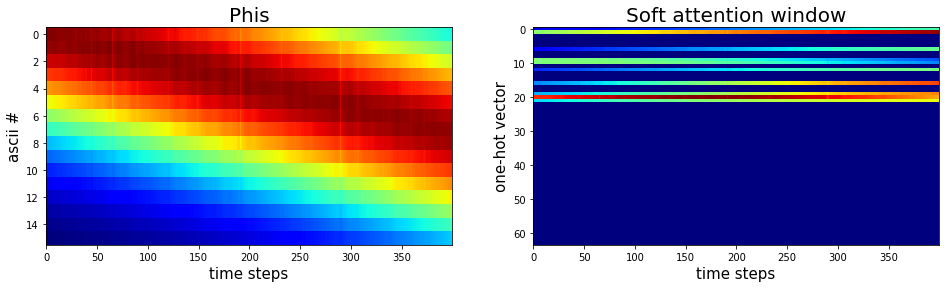

Epoch :  0  - step  10 / 548  - loss  898.0026245117188  in  11.433812856674194
Epoch :  0  - step  20 / 548  - loss  559.4588012695312  in  10.421599626541138
Epoch :  0  - step  30 / 548  - loss  400.0921630859375  in  10.461542844772339
Epoch :  0  - step  40 / 548  - loss  439.63824462890625  in  10.426180601119995
Epoch :  0  - step  50 / 548  - loss  337.48431396484375  in  10.415718793869019
Epoch :  0  - step  60 / 548  - loss  245.9984130859375  in  10.525074005126953
Epoch :  0  - step  70 / 548  - loss  198.74880981445312  in  10.520989418029785
Epoch :  0  - step  80 / 548  - loss  309.9896240234375  in  10.41214656829834
Epoch :  0  - step  90 / 548  - loss  162.9196014404297  in  10.468711137771606
Epoch :  0  - step  100 / 548  - loss  118.65709686279297  in  10.398541927337646


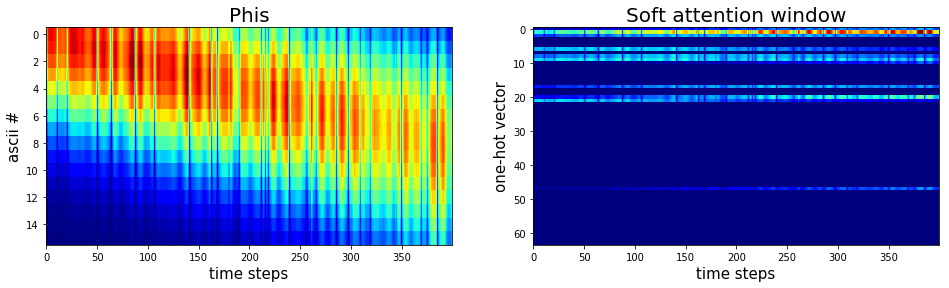

Epoch :  0  - step  110 / 548  - loss  157.7616424560547  in  10.779263019561768
Epoch :  0  - step  120 / 548  - loss  84.2375259399414  in  10.631849527359009
Epoch :  0  - step  130 / 548  - loss  143.29229736328125  in  10.436275959014893
Epoch :  0  - step  140 / 548  - loss  105.6097183227539  in  10.472069025039673
Epoch :  0  - step  150 / 548  - loss  99.58843231201172  in  10.433342695236206
Epoch :  0  - step  160 / 548  - loss  120.62572479248047  in  10.4784677028656
Epoch :  0  - step  170 / 548  - loss  145.0350341796875  in  10.430135250091553
Epoch :  0  - step  180 / 548  - loss  62.78896713256836  in  10.526590347290039
Epoch :  0  - step  190 / 548  - loss  118.7282485961914  in  10.45707368850708
Epoch :  0  - step  200 / 548  - loss  102.81066131591797  in  10.411431789398193


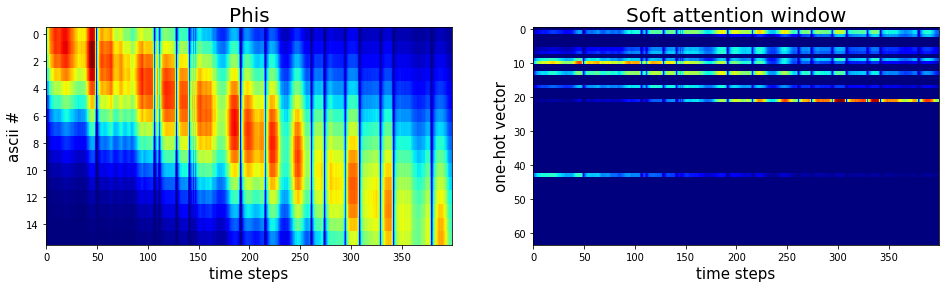

Epoch :  0  - step  210 / 548  - loss  117.09215545654297  in  10.714415311813354
Epoch :  0  - step  220 / 548  - loss  54.3817253112793  in  10.455349445343018
Epoch :  0  - step  230 / 548  - loss  61.50087356567383  in  10.435936689376831
Epoch :  0  - step  240 / 548  - loss  58.82440185546875  in  10.46596622467041
Epoch :  0  - step  250 / 548  - loss  58.06327438354492  in  10.410343885421753
Epoch :  0  - step  260 / 548  - loss  88.7737045288086  in  10.409560680389404
Epoch :  0  - step  270 / 548  - loss  120.68949127197266  in  10.460399389266968
Epoch :  0  - step  280 / 548  - loss  139.0889892578125  in  10.411427974700928
Epoch :  0  - step  290 / 548  - loss  112.54906463623047  in  10.416363954544067
Epoch :  0  - step  300 / 548  - loss  55.80863571166992  in  10.534825325012207


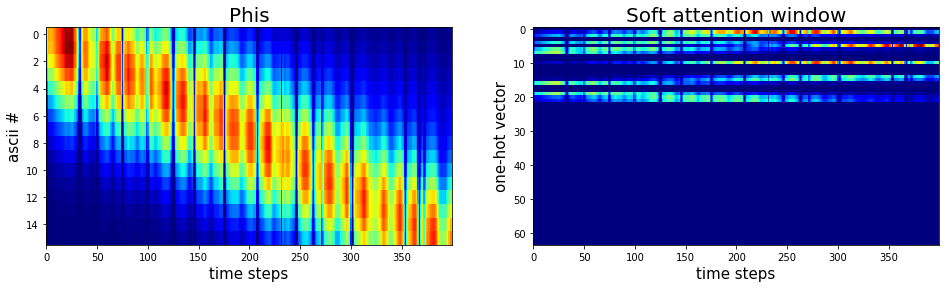

Epoch :  0  - step  310 / 548  - loss  118.9342269897461  in  10.74884033203125
Epoch :  0  - step  320 / 548  - loss  102.72041320800781  in  10.500180006027222
Epoch :  0  - step  330 / 548  - loss  107.12841033935547  in  10.448533773422241
Epoch :  0  - step  340 / 548  - loss  24.346923828125  in  11.15352988243103
Epoch :  0  - step  350 / 548  - loss  -5.3889641761779785  in  11.206788063049316
Epoch :  0  - step  360 / 548  - loss  72.10039520263672  in  10.849307298660278
Epoch :  0  - step  370 / 548  - loss  8.546290397644043  in  10.78450894355774
Epoch :  0  - step  380 / 548  - loss  57.481536865234375  in  10.57805347442627
Epoch :  0  - step  390 / 548  - loss  47.23677444458008  in  11.223215579986572
Epoch :  0  - step  400 / 548  - loss  58.37276840209961  in  12.897062540054321


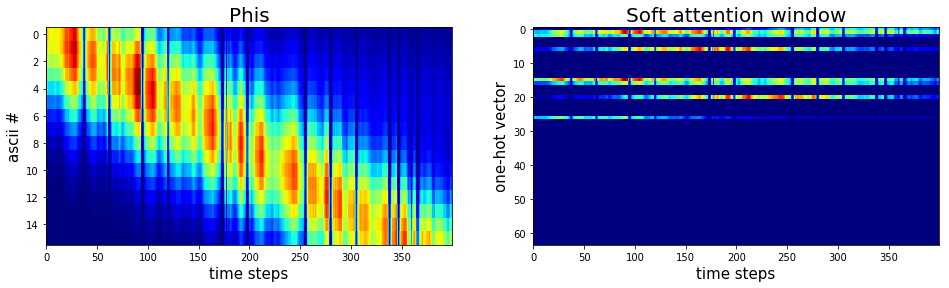

Epoch :  0  - step  410 / 548  - loss  142.49461364746094  in  11.058945417404175
Epoch :  0  - step  420 / 548  - loss  115.33910369873047  in  10.578278064727783
Epoch :  0  - step  430 / 548  - loss  58.363311767578125  in  11.191651344299316
Epoch :  0  - step  440 / 548  - loss  45.19489669799805  in  11.085498571395874
Epoch :  0  - step  450 / 548  - loss  30.838605880737305  in  11.811110734939575
Epoch :  0  - step  460 / 548  - loss  27.714445114135742  in  11.020318746566772
Epoch :  0  - step  470 / 548  - loss  90.65509033203125  in  10.419489622116089
Epoch :  0  - step  480 / 548  - loss  98.66341400146484  in  10.468207120895386
Epoch :  0  - step  490 / 548  - loss  33.71320343017578  in  10.41869330406189
Epoch :  0  - step  500 / 548  - loss  73.21630859375  in  10.466202735900879


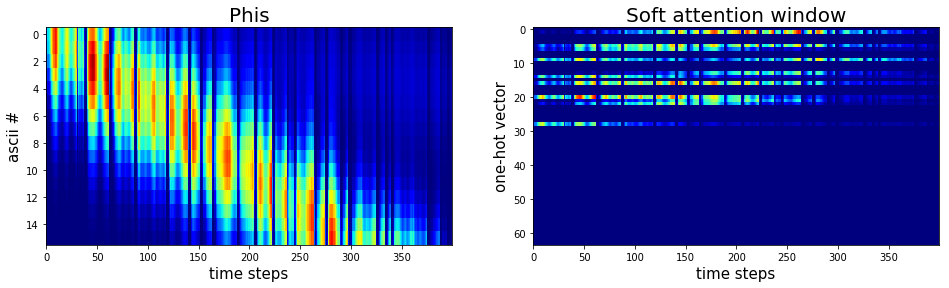

Epoch :  0  - step  510 / 548  - loss  73.72538757324219  in  10.724254846572876
Epoch :  0  - step  520 / 548  - loss  24.74267578125  in  10.553571462631226
Epoch :  0  - step  530 / 548  - loss  196.27500915527344  in  10.468030452728271
Epoch :  0  - step  540 / 548  - loss  230.8148956298828  in  10.428824424743652
Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


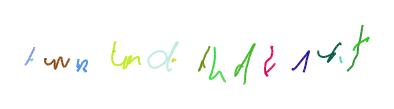

pointer reset
Epoch :  1  - step  0 / 548  - loss  76.88348388671875  in  118.98659181594849


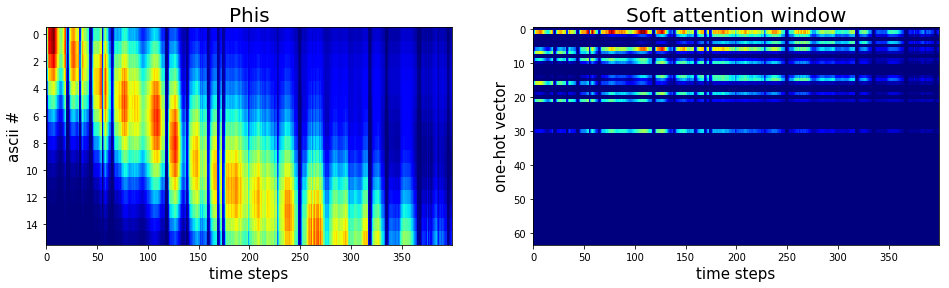

Epoch :  1  - step  10 / 548  - loss  26.346647262573242  in  10.76130199432373
Epoch :  1  - step  20 / 548  - loss  75.44524383544922  in  10.41946792602539
Epoch :  1  - step  30 / 548  - loss  34.09724044799805  in  10.425081491470337
Epoch :  1  - step  40 / 548  - loss  66.20140838623047  in  10.469486236572266
Epoch :  1  - step  50 / 548  - loss  48.98684310913086  in  10.428735971450806
Epoch :  1  - step  60 / 548  - loss  22.905553817749023  in  10.474965572357178
Epoch :  1  - step  70 / 548  - loss  76.7793197631836  in  10.427135229110718
Epoch :  1  - step  80 / 548  - loss  28.547149658203125  in  10.437090396881104
Epoch :  1  - step  90 / 548  - loss  58.35445785522461  in  11.076318264007568
Epoch :  1  - step  100 / 548  - loss  74.18860626220703  in  11.354021549224854


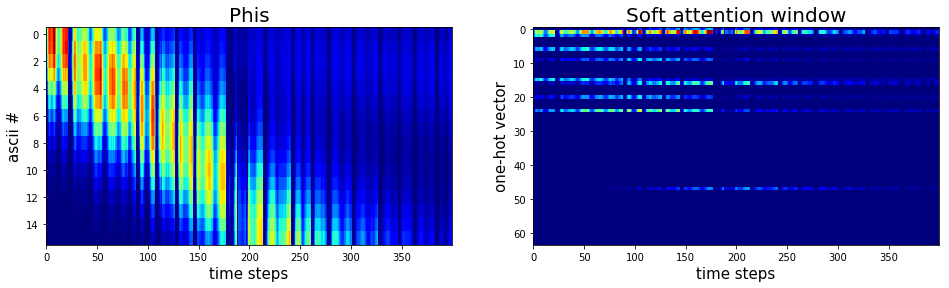

Epoch :  1  - step  110 / 548  - loss  167.78480529785156  in  11.164191246032715
Epoch :  1  - step  120 / 548  - loss  -0.23012618720531464  in  11.368821859359741
Epoch :  1  - step  130 / 548  - loss  119.50724029541016  in  10.722883462905884
Epoch :  1  - step  140 / 548  - loss  66.43094635009766  in  11.820177793502808
Epoch :  1  - step  150 / 548  - loss  120.2442855834961  in  11.069719314575195
Epoch :  1  - step  160 / 548  - loss  117.41178131103516  in  12.09896206855774
Epoch :  1  - step  170 / 548  - loss  108.2394790649414  in  10.787265300750732
Epoch :  1  - step  180 / 548  - loss  57.9019660949707  in  11.371937990188599
Epoch :  1  - step  190 / 548  - loss  25.43836784362793  in  11.36322283744812
Epoch :  1  - step  200 / 548  - loss  145.9959259033203  in  10.81727147102356


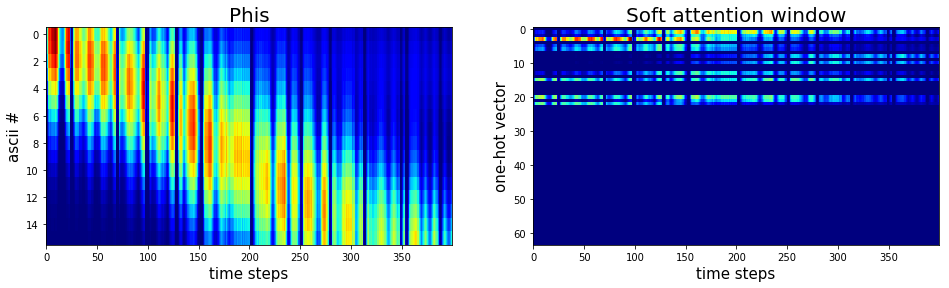

Epoch :  1  - step  210 / 548  - loss  37.27102279663086  in  11.452478885650635
Epoch :  1  - step  220 / 548  - loss  28.23224449157715  in  11.30745816230774
Epoch :  1  - step  230 / 548  - loss  -7.504266262054443  in  11.789524555206299
Epoch :  1  - step  240 / 548  - loss  23.814809799194336  in  10.885340452194214
Epoch :  1  - step  250 / 548  - loss  70.46017456054688  in  10.55914568901062
Epoch :  1  - step  260 / 548  - loss  51.312843322753906  in  10.461398363113403
Epoch :  1  - step  270 / 548  - loss  3.703274965286255  in  10.522443771362305
Epoch :  1  - step  280 / 548  - loss  99.0330810546875  in  10.469674110412598
Epoch :  1  - step  290 / 548  - loss  76.91323852539062  in  10.467915296554565
Epoch :  1  - step  300 / 548  - loss  36.65953826904297  in  10.540332794189453


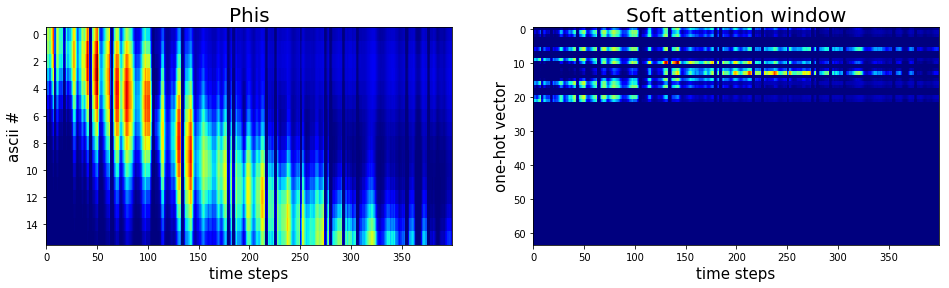

Epoch :  1  - step  310 / 548  - loss  134.6754608154297  in  10.900659322738647
Epoch :  1  - step  320 / 548  - loss  42.101444244384766  in  10.525453329086304
Epoch :  1  - step  330 / 548  - loss  89.42059326171875  in  10.46718692779541
Epoch :  1  - step  340 / 548  - loss  156.43292236328125  in  10.457590818405151
Epoch :  1  - step  350 / 548  - loss  123.2116928100586  in  10.505820512771606
Epoch :  1  - step  360 / 548  - loss  208.64244079589844  in  10.464733839035034
Epoch :  1  - step  370 / 548  - loss  39.962974548339844  in  10.456859111785889
Epoch :  1  - step  380 / 548  - loss  185.2181854248047  in  10.496846914291382
Epoch :  1  - step  390 / 548  - loss  22.730192184448242  in  10.44150996208191
Epoch :  1  - step  400 / 548  - loss  60.206451416015625  in  10.497678995132446


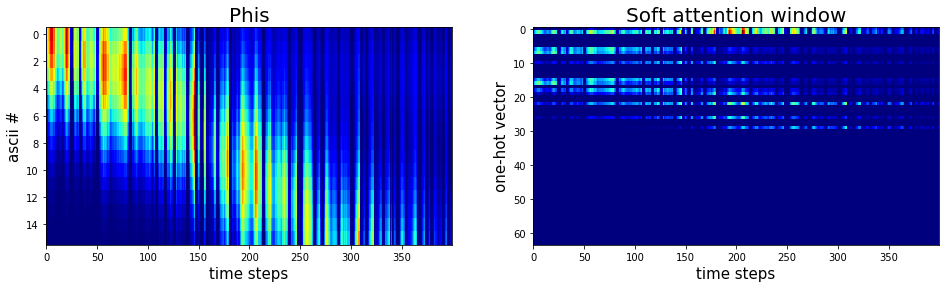

Epoch :  1  - step  410 / 548  - loss  35.0906982421875  in  10.7530357837677
Epoch :  1  - step  420 / 548  - loss  -7.480119228363037  in  10.528713464736938
Epoch :  1  - step  430 / 548  - loss  88.7960433959961  in  10.551217794418335
Epoch :  1  - step  440 / 548  - loss  255.7938995361328  in  10.440781116485596
Epoch :  1  - step  450 / 548  - loss  77.4500732421875  in  10.443155765533447
Epoch :  1  - step  460 / 548  - loss  133.1514892578125  in  10.506584644317627
Epoch :  1  - step  470 / 548  - loss  44.47715377807617  in  10.451422929763794
Epoch :  1  - step  480 / 548  - loss  132.5772247314453  in  10.496686697006226
Epoch :  1  - step  490 / 548  - loss  124.8777084350586  in  10.462065696716309
Epoch :  1  - step  500 / 548  - loss  68.20838165283203  in  10.447269201278687


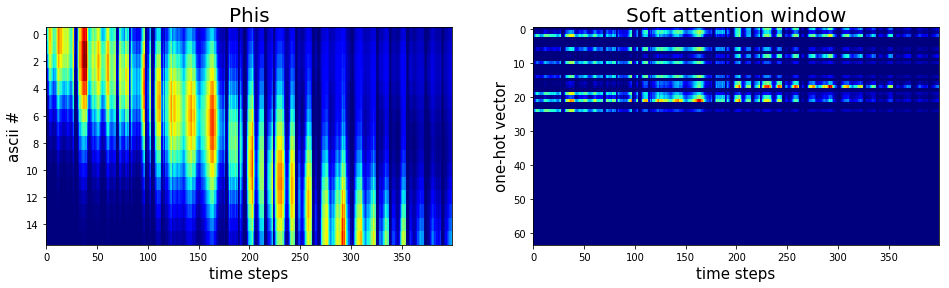

Epoch :  1  - step  510 / 548  - loss  68.35210418701172  in  10.801664590835571
Epoch :  1  - step  520 / 548  - loss  85.96019744873047  in  10.45746922492981
Epoch :  1  - step  530 / 548  - loss  7.324477672576904  in  10.634202241897583
Epoch :  1  - step  540 / 548  - loss  119.73674774169922  in  11.955769538879395
Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


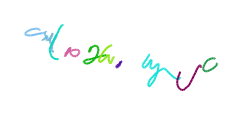

pointer reset
Epoch :  2  - step  0 / 548  - loss  139.89707946777344  in  118.7678611278534


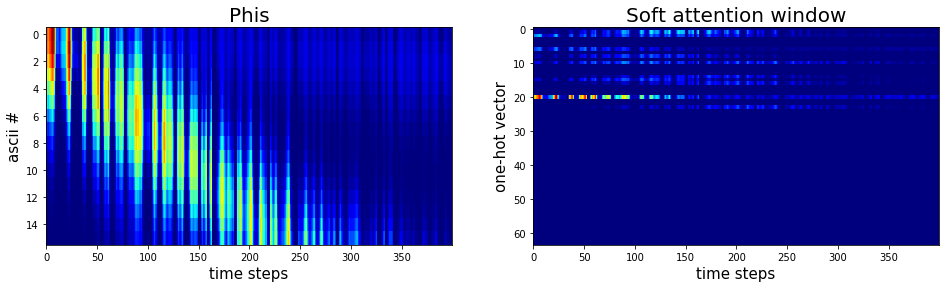

Epoch :  2  - step  10 / 548  - loss  101.73607635498047  in  10.754512071609497
Epoch :  2  - step  20 / 548  - loss  25.362905502319336  in  10.389684915542603
Epoch :  2  - step  30 / 548  - loss  72.96642303466797  in  10.393065214157104
Epoch :  2  - step  40 / 548  - loss  93.22692108154297  in  10.45858645439148
Epoch :  2  - step  50 / 548  - loss  55.48396682739258  in  10.413828372955322
Epoch :  2  - step  60 / 548  - loss  -20.561012268066406  in  10.435800790786743
Epoch :  2  - step  70 / 548  - loss  30.433591842651367  in  11.23280644416809
Epoch :  2  - step  80 / 548  - loss  31.17713737487793  in  11.315757989883423
Epoch :  2  - step  90 / 548  - loss  -22.421812057495117  in  10.895849227905273
Epoch :  2  - step  100 / 548  - loss  10.11579418182373  in  10.90172791481018


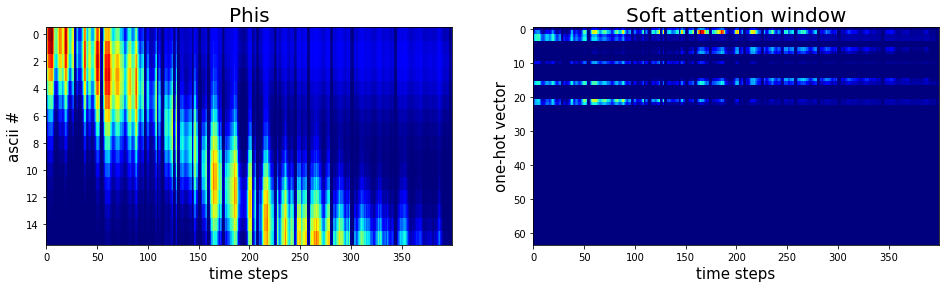

Epoch :  2  - step  110 / 548  - loss  62.81264114379883  in  11.29452109336853
Epoch :  2  - step  120 / 548  - loss  28.407337188720703  in  11.29538106918335
Epoch :  2  - step  130 / 548  - loss  34.89229202270508  in  11.031788110733032
Epoch :  2  - step  140 / 548  - loss  56.40668869018555  in  11.019264459609985
Epoch :  2  - step  150 / 548  - loss  61.14336013793945  in  10.877247333526611
Epoch :  2  - step  160 / 548  - loss  15.558321952819824  in  10.6658935546875
Epoch :  2  - step  170 / 548  - loss  7.8775482177734375  in  11.17896842956543
Epoch :  2  - step  180 / 548  - loss  -10.0  in  11.429152727127075
Epoch :  2  - step  190 / 548  - loss  34.82455062866211  in  11.067121982574463
Epoch :  2  - step  200 / 548  - loss  8.9685640335083  in  10.657642841339111


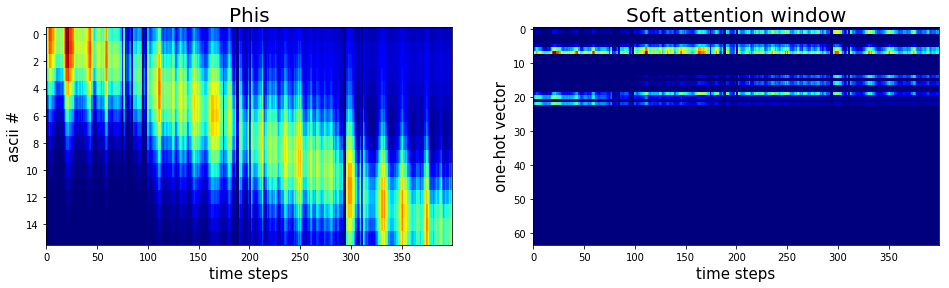

Epoch :  2  - step  210 / 548  - loss  37.69105529785156  in  11.045177459716797
Epoch :  2  - step  220 / 548  - loss  85.57734680175781  in  11.347513675689697
Epoch :  2  - step  230 / 548  - loss  15.337115287780762  in  10.715696811676025
Epoch :  2  - step  240 / 548  - loss  55.2222785949707  in  10.977660417556763
Epoch :  2  - step  250 / 548  - loss  94.76737976074219  in  10.529513835906982
Epoch :  2  - step  260 / 548  - loss  20.147464752197266  in  10.473270177841187
Epoch :  2  - step  270 / 548  - loss  22.725553512573242  in  10.542771339416504
Epoch :  2  - step  280 / 548  - loss  40.86385726928711  in  10.467243432998657
Epoch :  2  - step  290 / 548  - loss  -3.314382314682007  in  10.466423273086548
Epoch :  2  - step  300 / 548  - loss  -16.213729858398438  in  10.522664546966553


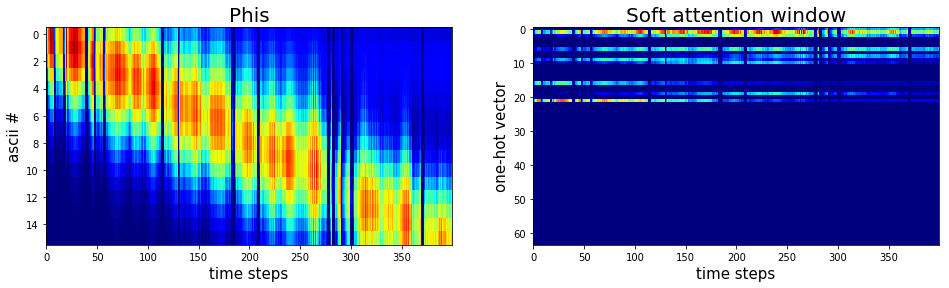

Epoch :  2  - step  310 / 548  - loss  8.721145629882812  in  10.778541564941406
Epoch :  2  - step  320 / 548  - loss  68.6332778930664  in  10.625362873077393
Epoch :  2  - step  330 / 548  - loss  -58.747859954833984  in  10.834142208099365
Epoch :  2  - step  340 / 548  - loss  73.37144470214844  in  10.846137523651123
Epoch :  2  - step  350 / 548  - loss  77.79240417480469  in  10.767133951187134
Epoch :  2  - step  360 / 548  - loss  189.4957275390625  in  10.569982051849365
Epoch :  2  - step  370 / 548  - loss  51.293701171875  in  10.561557292938232
Epoch :  2  - step  380 / 548  - loss  1.396431803703308  in  10.629952907562256
Epoch :  2  - step  390 / 548  - loss  29.26057243347168  in  10.537850379943848
Epoch :  2  - step  400 / 548  - loss  8.961456298828125  in  10.726154804229736


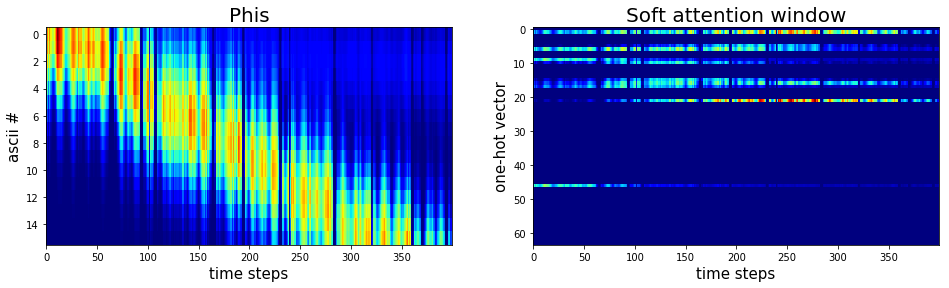

Epoch :  2  - step  410 / 548  - loss  56.365081787109375  in  11.279345750808716
Epoch :  2  - step  420 / 548  - loss  31.503662109375  in  10.711122751235962
Epoch :  2  - step  430 / 548  - loss  52.968109130859375  in  10.548179149627686
Epoch :  2  - step  440 / 548  - loss  24.240217208862305  in  10.665313482284546
Epoch :  2  - step  450 / 548  - loss  -13.1757173538208  in  10.481394052505493
Epoch :  2  - step  460 / 548  - loss  -16.54938316345215  in  10.590912580490112
Epoch :  2  - step  470 / 548  - loss  -8.369903564453125  in  10.519052505493164
Epoch :  2  - step  480 / 548  - loss  -27.764892578125  in  10.58771562576294
Epoch :  2  - step  490 / 548  - loss  23.706838607788086  in  10.525707244873047
Epoch :  2  - step  500 / 548  - loss  23.520965576171875  in  10.51222276687622


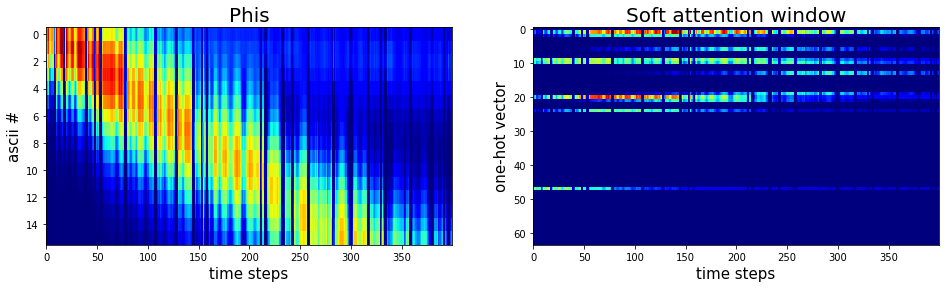

Epoch :  2  - step  510 / 548  - loss  69.10306549072266  in  10.876721858978271
Epoch :  2  - step  520 / 548  - loss  85.04149627685547  in  10.509233236312866
Epoch :  2  - step  530 / 548  - loss  -56.61377716064453  in  10.603475332260132
Epoch :  2  - step  540 / 548  - loss  52.29443359375  in  10.514598369598389
Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


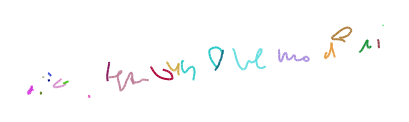

pointer reset
Epoch :  3  - step  0 / 548  - loss  19.651905059814453  in  119.62103724479675


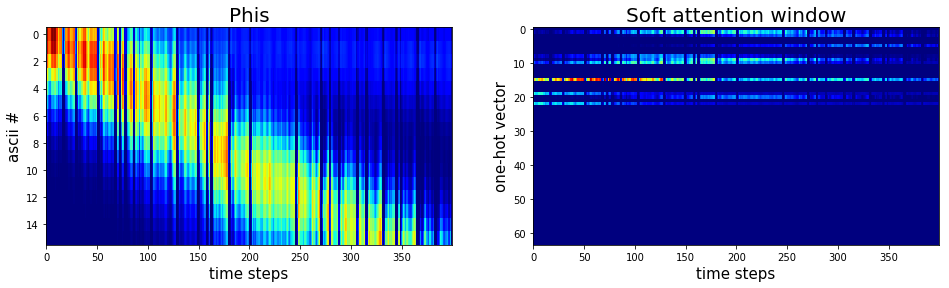

Epoch :  3  - step  10 / 548  - loss  19.67294692993164  in  10.877447128295898
Epoch :  3  - step  20 / 548  - loss  -56.44578170776367  in  11.14326286315918
Epoch :  3  - step  30 / 548  - loss  -6.437970161437988  in  10.997953414916992
Epoch :  3  - step  40 / 548  - loss  43.08930587768555  in  11.103096008300781
Epoch :  3  - step  50 / 548  - loss  10.70638370513916  in  11.065520763397217
Epoch :  3  - step  60 / 548  - loss  51.69295883178711  in  10.540443658828735
Epoch :  3  - step  70 / 548  - loss  -42.5922966003418  in  10.637750625610352
Epoch :  3  - step  80 / 548  - loss  -52.89581298828125  in  10.522049188613892
Epoch :  3  - step  90 / 548  - loss  14.816655158996582  in  10.583633184432983
Epoch :  3  - step  100 / 548  - loss  6.965272426605225  in  10.538753747940063


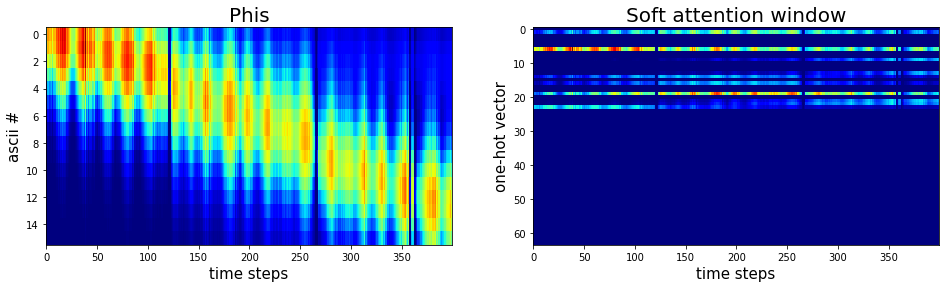

Epoch :  3  - step  110 / 548  - loss  -16.983179092407227  in  10.779290914535522
Epoch :  3  - step  120 / 548  - loss  -33.98220443725586  in  10.549216270446777
Epoch :  3  - step  130 / 548  - loss  38.58106994628906  in  10.616907596588135
Epoch :  3  - step  140 / 548  - loss  -44.96632385253906  in  10.576005458831787
Epoch :  3  - step  150 / 548  - loss  22.427717208862305  in  10.52132272720337
Epoch :  3  - step  160 / 548  - loss  -51.14778518676758  in  10.51783275604248
Epoch :  3  - step  170 / 548  - loss  -60.14192581176758  in  10.600145101547241
Epoch :  3  - step  180 / 548  - loss  -6.152273654937744  in  10.53060793876648
Epoch :  3  - step  190 / 548  - loss  29.471023559570312  in  10.521475076675415
Epoch :  3  - step  200 / 548  - loss  18.74237632751465  in  10.608031749725342


/home/gnocchi/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


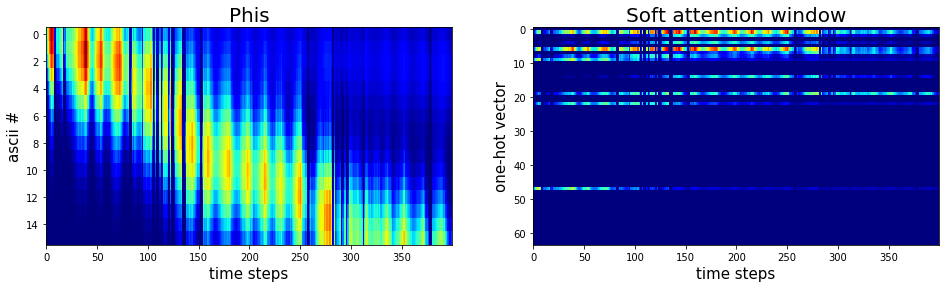

Epoch :  3  - step  210 / 548  - loss  10.42923355102539  in  10.809231281280518
Epoch :  3  - step  220 / 548  - loss  26.478076934814453  in  10.603789329528809
Epoch :  3  - step  230 / 548  - loss  -37.28129959106445  in  10.535625219345093
Epoch :  3  - step  240 / 548  - loss  -13.21882152557373  in  10.621137619018555
Epoch :  3  - step  250 / 548  - loss  -49.04677200317383  in  10.595511674880981
Epoch :  3  - step  260 / 548  - loss  11.39447021484375  in  10.508867263793945
Epoch :  3  - step  270 / 548  - loss  49.15300750732422  in  10.524319887161255
Epoch :  3  - step  280 / 548  - loss  -33.6157341003418  in  10.595672130584717
Epoch :  3  - step  290 / 548  - loss  92.6717758178711  in  10.512438535690308
Epoch :  3  - step  300 / 548  - loss  -28.484806060791016  in  10.522656202316284


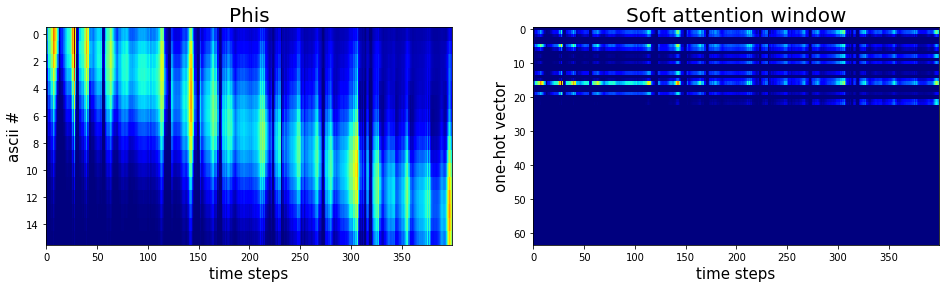

Epoch :  3  - step  310 / 548  - loss  56.447078704833984  in  10.891457557678223
Epoch :  3  - step  320 / 548  - loss  -45.22872543334961  in  10.518631219863892
Epoch :  3  - step  330 / 548  - loss  37.974700927734375  in  10.632384061813354
Epoch :  3  - step  340 / 548  - loss  3.418501377105713  in  11.876731634140015
Epoch :  3  - step  350 / 548  - loss  -43.935699462890625  in  10.597661018371582
Epoch :  3  - step  360 / 548  - loss  -54.65767288208008  in  10.563280582427979
Epoch :  3  - step  370 / 548  - loss  -23.5645751953125  in  10.470487833023071
Epoch :  3  - step  380 / 548  - loss  -1.6722904443740845  in  10.470782995223999
Epoch :  3  - step  390 / 548  - loss  60.86045455932617  in  10.545073509216309
Epoch :  3  - step  400 / 548  - loss  -29.11734962463379  in  10.484200477600098


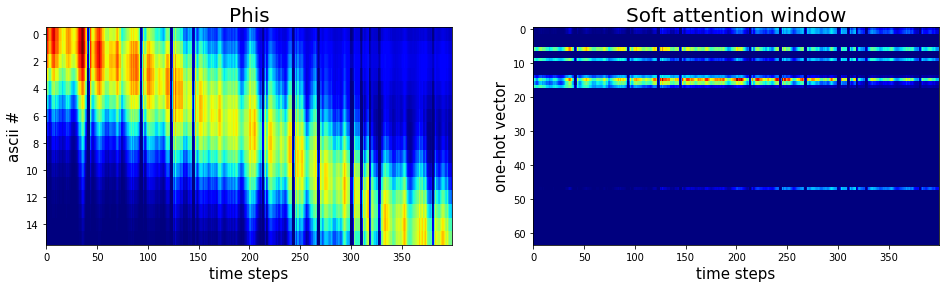

Epoch :  3  - step  410 / 548  - loss  14.421043395996094  in  10.764400005340576
Epoch :  3  - step  420 / 548  - loss  74.14238739013672  in  10.565914154052734
Epoch :  3  - step  430 / 548  - loss  98.24476623535156  in  10.46328067779541
Epoch :  3  - step  440 / 548  - loss  97.29257202148438  in  10.45358419418335
Epoch :  3  - step  450 / 548  - loss  107.35188293457031  in  10.520333528518677
Epoch :  3  - step  460 / 548  - loss  -28.810888290405273  in  10.44523286819458
Epoch :  3  - step  470 / 548  - loss  20.901538848876953  in  10.542073488235474
Epoch :  3  - step  480 / 548  - loss  -23.07192611694336  in  10.507052421569824
Epoch :  3  - step  490 / 548  - loss  -57.56373977661133  in  10.441394329071045
Epoch :  3  - step  500 / 548  - loss  22.528593063354492  in  10.509105443954468


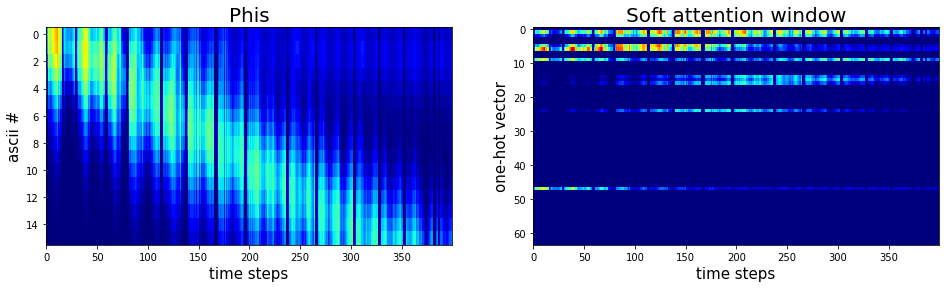

Epoch :  3  - step  510 / 548  - loss  39.66501235961914  in  10.744853973388672
Epoch :  3  - step  520 / 548  - loss  -33.210201263427734  in  10.443771600723267
Epoch :  3  - step  530 / 548  - loss  -32.04096603393555  in  10.515922784805298
Epoch :  3  - step  540 / 548  - loss  -47.44175338745117  in  10.440896034240723
Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


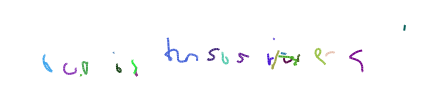

pointer reset
Epoch :  4  - step  0 / 548  - loss  134.96910095214844  in  119.47739887237549


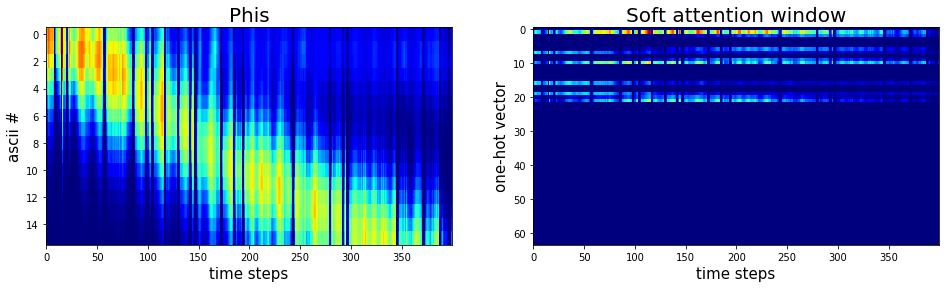

Epoch :  4  - step  10 / 548  - loss  52.97407150268555  in  10.812825202941895
Epoch :  4  - step  20 / 548  - loss  41.54398727416992  in  10.455618619918823
Epoch :  4  - step  30 / 548  - loss  35.15372848510742  in  10.453556299209595
Epoch :  4  - step  40 / 548  - loss  3.8487374782562256  in  10.642591714859009
Epoch :  4  - step  50 / 548  - loss  -44.106319427490234  in  10.483130693435669
Epoch :  4  - step  60 / 548  - loss  63.98297119140625  in  10.470665454864502
Epoch :  4  - step  70 / 548  - loss  108.17445373535156  in  10.554760217666626
Epoch :  4  - step  80 / 548  - loss  174.423095703125  in  10.473376512527466
Epoch :  4  - step  90 / 548  - loss  64.77705383300781  in  10.470674514770508
Epoch :  4  - step  100 / 548  - loss  62.604793548583984  in  10.556591033935547


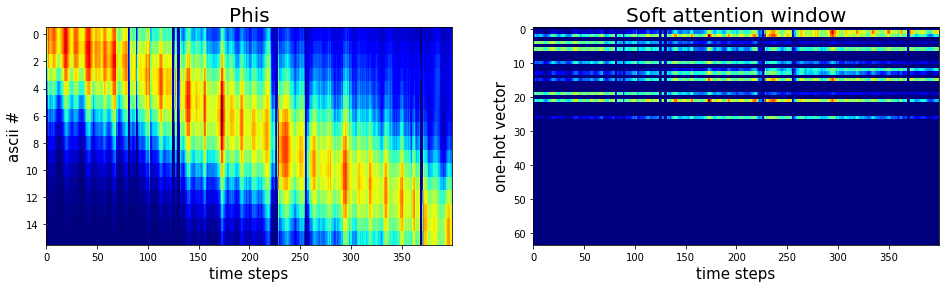

Epoch :  4  - step  110 / 548  - loss  94.41002655029297  in  10.772944688796997
Epoch :  4  - step  120 / 548  - loss  45.94937515258789  in  10.566093444824219
Epoch :  4  - step  130 / 548  - loss  79.6378402709961  in  10.46996545791626
Epoch :  4  - step  140 / 548  - loss  18.625261306762695  in  10.480490684509277
Epoch :  4  - step  150 / 548  - loss  -34.68043899536133  in  10.569271802902222
Epoch :  4  - step  160 / 548  - loss  13.211906433105469  in  10.573383569717407
Epoch :  4  - step  170 / 548  - loss  34.00068283081055  in  10.467006921768188
Epoch :  4  - step  180 / 548  - loss  64.54346466064453  in  10.531987190246582
Epoch :  4  - step  190 / 548  - loss  131.6859130859375  in  10.46076226234436
Epoch :  4  - step  200 / 548  - loss  169.35598754882812  in  10.460307598114014


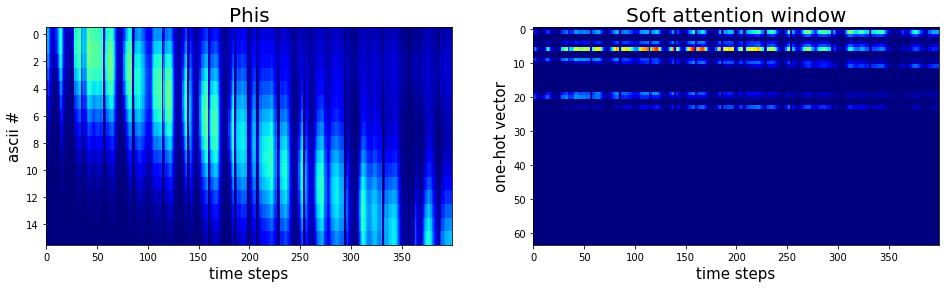

Epoch :  4  - step  210 / 548  - loss  202.82177734375  in  10.811841249465942
Epoch :  4  - step  220 / 548  - loss  564.9497680664062  in  10.491135835647583
Epoch :  4  - step  230 / 548  - loss  212.0251922607422  in  10.491883039474487
Epoch :  4  - step  240 / 548  - loss  189.2638397216797  in  10.567988157272339
Epoch :  4  - step  250 / 548  - loss  177.10964965820312  in  10.491546154022217
Epoch :  4  - step  260 / 548  - loss  134.3071746826172  in  10.521028995513916
Epoch :  4  - step  270 / 548  - loss  72.80791473388672  in  10.651843309402466
Epoch :  4  - step  280 / 548  - loss  162.1272430419922  in  10.507987976074219
Epoch :  4  - step  290 / 548  - loss  57.499202728271484  in  10.485910415649414
Epoch :  4  - step  300 / 548  - loss  13.874902725219727  in  10.582414627075195


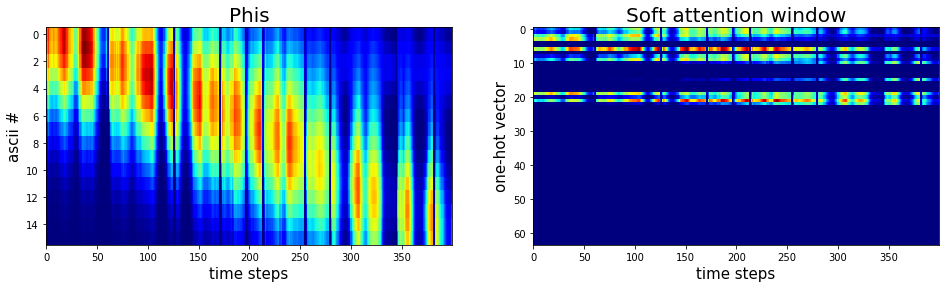

Epoch :  4  - step  310 / 548  - loss  -26.849212646484375  in  10.78691577911377
Epoch :  4  - step  320 / 548  - loss  33.081398010253906  in  10.49271845817566
Epoch :  4  - step  330 / 548  - loss  -59.96303176879883  in  10.572793006896973
Epoch :  4  - step  340 / 548  - loss  36.51793670654297  in  10.488220930099487
Epoch :  4  - step  350 / 548  - loss  23.633310317993164  in  10.497565031051636
Epoch :  4  - step  360 / 548  - loss  22.588563919067383  in  10.570216417312622
Epoch :  4  - step  370 / 548  - loss  56.145965576171875  in  10.50156569480896
Epoch :  4  - step  380 / 548  - loss  -56.956085205078125  in  10.542520761489868
Epoch :  4  - step  390 / 548  - loss  -4.307502269744873  in  10.554642915725708
Epoch :  4  - step  400 / 548  - loss  58.823299407958984  in  10.453373908996582


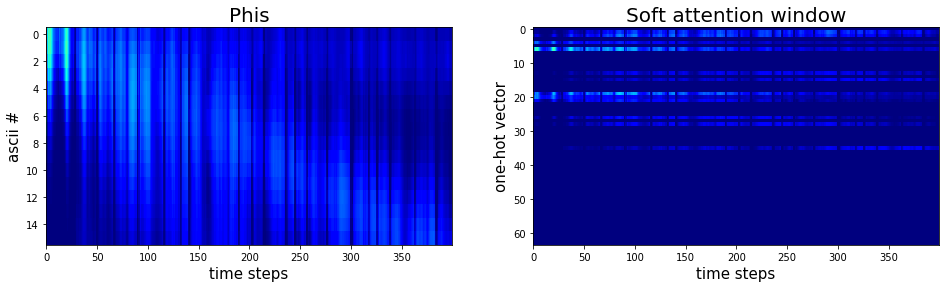

Epoch :  4  - step  410 / 548  - loss  -6.887243747711182  in  10.760497331619263
Epoch :  4  - step  420 / 548  - loss  44.248836517333984  in  10.547290086746216
Epoch :  4  - step  430 / 548  - loss  38.6526985168457  in  10.457672834396362
Epoch :  4  - step  440 / 548  - loss  29.105575561523438  in  10.875210523605347
Epoch :  4  - step  450 / 548  - loss  41.71189880371094  in  11.73955249786377
Epoch :  4  - step  460 / 548  - loss  107.7696304321289  in  11.187135457992554
Epoch :  4  - step  470 / 548  - loss  23.756641387939453  in  11.031489849090576
Epoch :  4  - step  480 / 548  - loss  30.497709274291992  in  10.51818561553955
Epoch :  4  - step  490 / 548  - loss  -5.121502876281738  in  11.495597124099731
Epoch :  4  - step  500 / 548  - loss  76.04988861083984  in  11.540931463241577


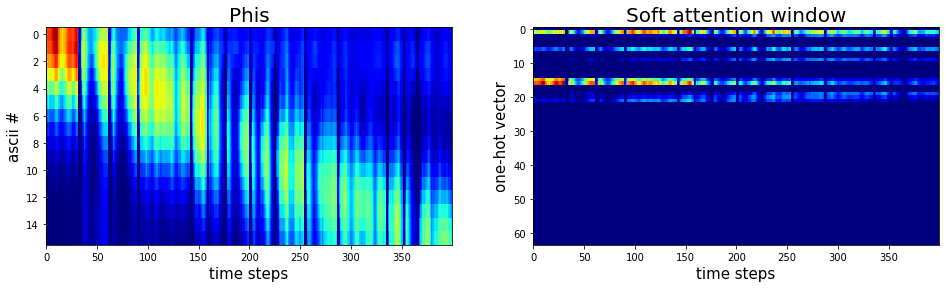

Epoch :  4  - step  510 / 548  - loss  46.676395416259766  in  10.95493459701538
Epoch :  4  - step  520 / 548  - loss  -18.939868927001953  in  10.568331718444824
Epoch :  4  - step  530 / 548  - loss  -42.52908706665039  in  10.551159620285034
Epoch :  4  - step  540 / 548  - loss  39.111167907714844  in  10.623902320861816
Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


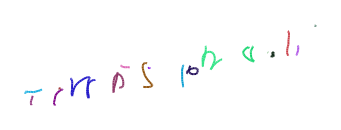

pointer reset
Epoch :  5  - step  0 / 548  - loss  40.037193298339844  in  120.42461347579956


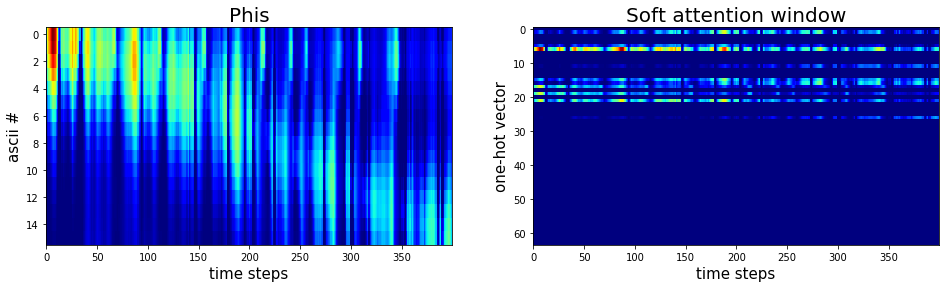

Epoch :  5  - step  10 / 548  - loss  28.1126708984375  in  10.803112983703613
Epoch :  5  - step  20 / 548  - loss  -1.1424225568771362  in  10.61308217048645
Epoch :  5  - step  30 / 548  - loss  -6.908880710601807  in  10.517255306243896
Epoch :  5  - step  40 / 548  - loss  55.31295394897461  in  10.539999961853027
Epoch :  5  - step  50 / 548  - loss  36.02924728393555  in  10.629351615905762
Epoch :  5  - step  60 / 548  - loss  75.29549407958984  in  10.608967304229736
Epoch :  5  - step  70 / 548  - loss  99.25896453857422  in  10.5757417678833
Epoch :  5  - step  80 / 548  - loss  62.9755859375  in  10.639740705490112
Epoch :  5  - step  90 / 548  - loss  28.2891902923584  in  10.543872594833374
Epoch :  5  - step  100 / 548  - loss  -31.016828536987305  in  10.537371635437012


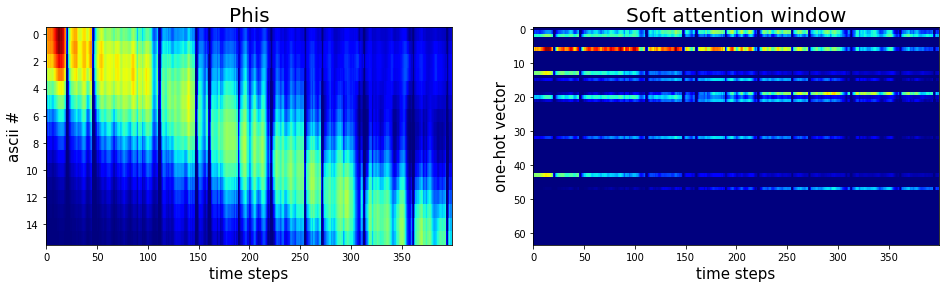

Epoch :  5  - step  110 / 548  - loss  118.5600357055664  in  10.912787199020386
Epoch :  5  - step  120 / 548  - loss  18.91496467590332  in  10.546202421188354
Epoch :  5  - step  130 / 548  - loss  113.5806655883789  in  10.866854667663574
Epoch :  5  - step  140 / 548  - loss  1.298366665840149  in  11.696841716766357
Epoch :  5  - step  150 / 548  - loss  54.26791000366211  in  10.570748805999756
Epoch :  5  - step  160 / 548  - loss  28.85883903503418  in  10.486735105514526
Epoch :  5  - step  170 / 548  - loss  14.328317642211914  in  10.557657480239868
Epoch :  5  - step  180 / 548  - loss  -2.0222465991973877  in  10.74360704421997
Epoch :  5  - step  190 / 548  - loss  23.516408920288086  in  10.502110719680786
Epoch :  5  - step  200 / 548  - loss  14.873160362243652  in  10.488309383392334


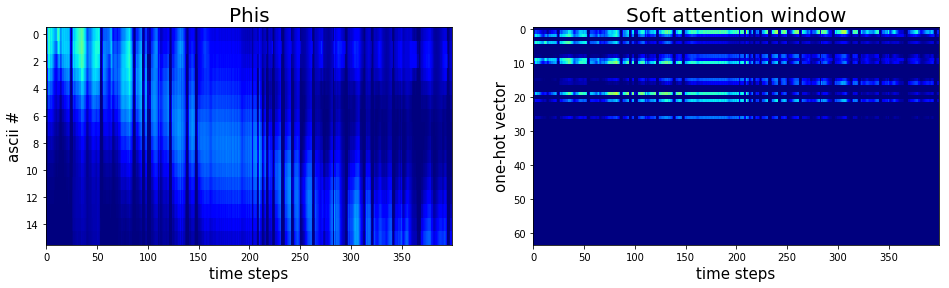

Epoch :  5  - step  210 / 548  - loss  7.958425998687744  in  10.86585783958435
Epoch :  5  - step  220 / 548  - loss  24.08820915222168  in  10.498613595962524
Epoch :  5  - step  230 / 548  - loss  31.013586044311523  in  10.929920673370361
Epoch :  5  - step  240 / 548  - loss  -5.587338924407959  in  10.576852083206177
Epoch :  5  - step  250 / 548  - loss  -8.057998657226562  in  10.468703508377075
Epoch :  5  - step  260 / 548  - loss  -18.77489471435547  in  10.468861103057861
Epoch :  5  - step  270 / 548  - loss  -18.036191940307617  in  10.45360779762268
Epoch :  5  - step  280 / 548  - loss  79.63346862792969  in  10.54966139793396
Epoch :  5  - step  290 / 548  - loss  39.34418487548828  in  10.607208251953125
Epoch :  5  - step  300 / 548  - loss  14.140131950378418  in  10.466577291488647


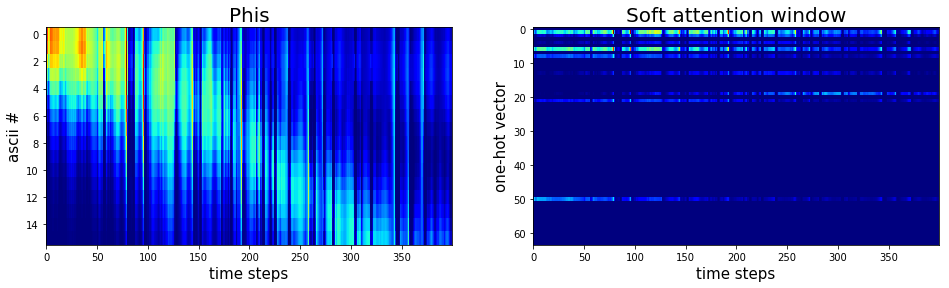

Epoch :  5  - step  310 / 548  - loss  50.40731430053711  in  10.897705316543579
Epoch :  5  - step  320 / 548  - loss  107.35884857177734  in  10.513415813446045
Epoch :  5  - step  330 / 548  - loss  31.196531295776367  in  10.494842052459717
Epoch :  5  - step  340 / 548  - loss  -33.26670837402344  in  10.578044652938843
Epoch :  5  - step  350 / 548  - loss  137.9633331298828  in  10.466280460357666
Epoch :  5  - step  360 / 548  - loss  15.584614753723145  in  10.456079006195068
Epoch :  5  - step  370 / 548  - loss  148.9088134765625  in  10.461822271347046
Epoch :  5  - step  380 / 548  - loss  193.0012664794922  in  10.581977367401123
Epoch :  5  - step  390 / 548  - loss  25.347549438476562  in  10.493575811386108
Epoch :  5  - step  400 / 548  - loss  33.077266693115234  in  10.55258560180664


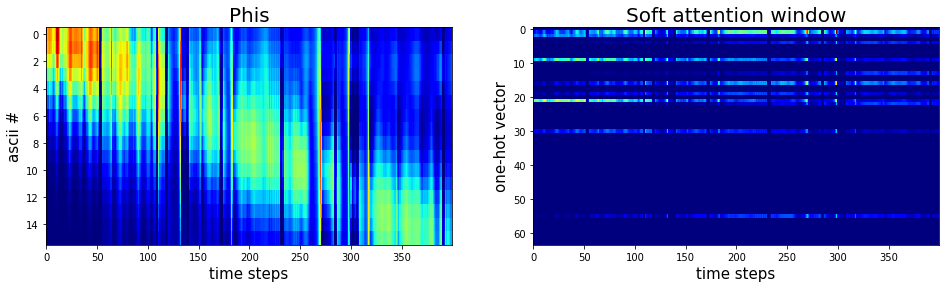

Epoch :  5  - step  410 / 548  - loss  58.40370559692383  in  10.881364107131958
Epoch :  5  - step  420 / 548  - loss  13.569968223571777  in  10.465409517288208
Epoch :  5  - step  430 / 548  - loss  45.77798843383789  in  10.462947845458984
Epoch :  5  - step  440 / 548  - loss  14.849469184875488  in  10.463900804519653
Epoch :  5  - step  450 / 548  - loss  46.96358108520508  in  10.572040319442749
Epoch :  5  - step  460 / 548  - loss  68.66053771972656  in  10.503711700439453
Epoch :  5  - step  470 / 548  - loss  31.400012969970703  in  10.463371276855469
Epoch :  5  - step  480 / 548  - loss  280.6607971191406  in  10.560866117477417
Epoch :  5  - step  490 / 548  - loss  202.77867126464844  in  10.490097284317017
Epoch :  5  - step  500 / 548  - loss  43.887413024902344  in  10.487127304077148


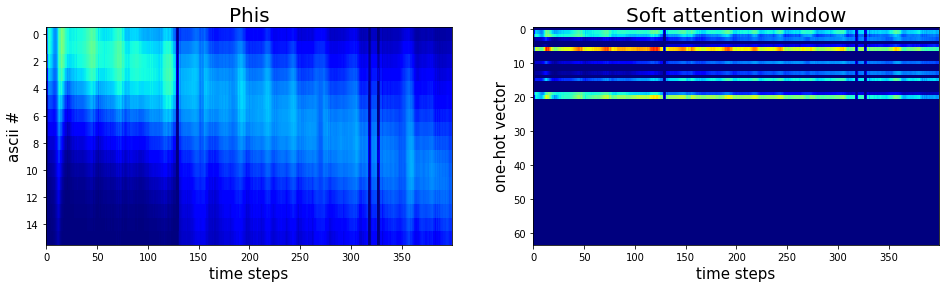

Epoch :  5  - step  510 / 548  - loss  76.8492660522461  in  10.766738414764404
Epoch :  5  - step  520 / 548  - loss  83.43505096435547  in  10.667726993560791
Epoch :  5  - step  530 / 548  - loss  24.674943923950195  in  10.48537278175354
Epoch :  5  - step  540 / 548  - loss  21.279682159423828  in  10.482736587524414
Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


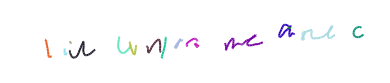

pointer reset
Epoch :  6  - step  0 / 548  - loss  -28.26019859313965  in  119.86084008216858


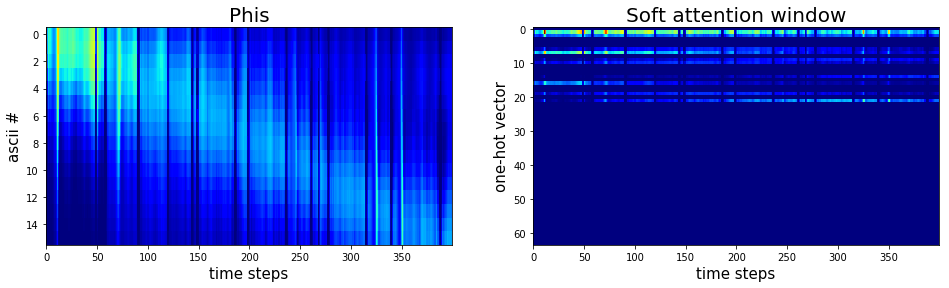

Epoch :  6  - step  10 / 548  - loss  23.960119247436523  in  10.740252494812012
Epoch :  6  - step  20 / 548  - loss  53.674163818359375  in  10.482808113098145
Epoch :  6  - step  30 / 548  - loss  -34.64342498779297  in  10.5641508102417
Epoch :  6  - step  40 / 548  - loss  68.43355560302734  in  10.474504232406616
Epoch :  6  - step  50 / 548  - loss  123.12220764160156  in  10.486756324768066
Epoch :  6  - step  60 / 548  - loss  102.92424774169922  in  10.585638284683228
Epoch :  6  - step  70 / 548  - loss  155.0194854736328  in  10.482066631317139
Epoch :  6  - step  80 / 548  - loss  159.3011016845703  in  10.49089241027832
Epoch :  6  - step  90 / 548  - loss  161.96824645996094  in  10.66946005821228
Epoch :  6  - step  100 / 548  - loss  157.65060424804688  in  10.60061001777649


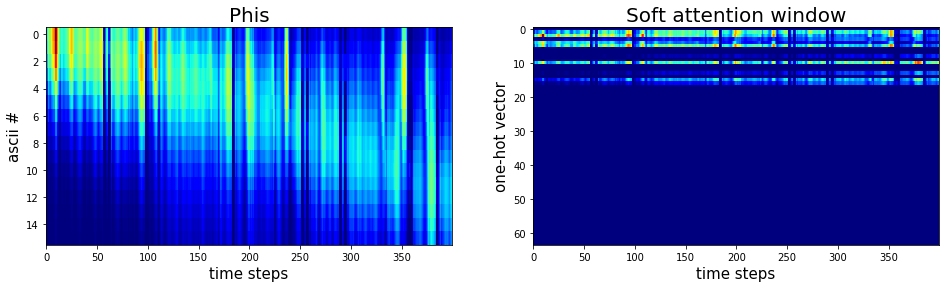

Epoch :  6  - step  110 / 548  - loss  114.68013000488281  in  10.771384477615356
Epoch :  6  - step  120 / 548  - loss  150.7323455810547  in  10.49131965637207
Epoch :  6  - step  130 / 548  - loss  163.6455535888672  in  10.585951805114746
Epoch :  6  - step  140 / 548  - loss  132.74659729003906  in  10.486492156982422
Epoch :  6  - step  150 / 548  - loss  244.88638305664062  in  10.491421699523926
Epoch :  6  - step  160 / 548  - loss  126.45478820800781  in  10.480361700057983
Epoch :  6  - step  170 / 548  - loss  115.7334213256836  in  10.59965968132019
Epoch :  6  - step  180 / 548  - loss  65.33222198486328  in  10.490307807922363
Epoch :  6  - step  190 / 548  - loss  152.7865753173828  in  10.483622074127197
Epoch :  6  - step  200 / 548  - loss  125.64637756347656  in  10.6055908203125


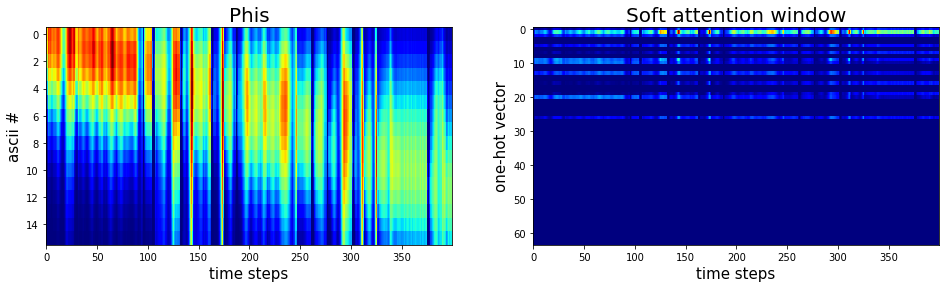

Epoch :  6  - step  210 / 548  - loss  164.77439880371094  in  11.325072526931763
Epoch :  6  - step  220 / 548  - loss  150.573974609375  in  11.767893552780151
Epoch :  6  - step  230 / 548  - loss  42.143245697021484  in  11.494877338409424
Epoch :  6  - step  240 / 548  - loss  123.96453857421875  in  11.369215965270996
Epoch :  6  - step  250 / 548  - loss  36.39424133300781  in  11.446351289749146
Epoch :  6  - step  260 / 548  - loss  70.3293685913086  in  11.006188869476318
Epoch :  6  - step  270 / 548  - loss  9.084500312805176  in  11.253904342651367
Epoch :  6  - step  280 / 548  - loss  38.7068977355957  in  10.968897581100464
Epoch :  6  - step  290 / 548  - loss  -4.428610324859619  in  12.466898441314697
Epoch :  6  - step  300 / 548  - loss  50.9627799987793  in  11.500161170959473


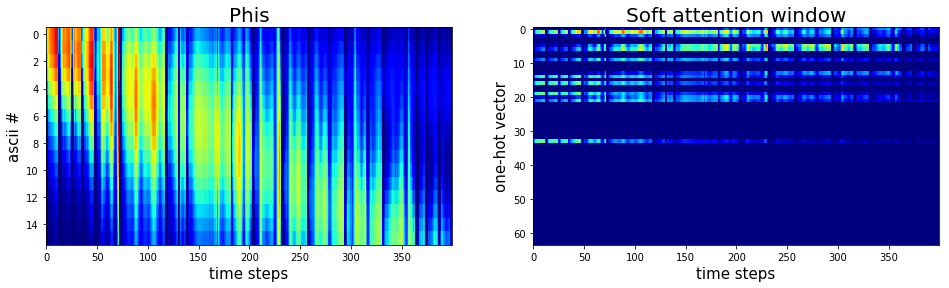

Epoch :  6  - step  310 / 548  - loss  -48.559749603271484  in  11.894765377044678
Epoch :  6  - step  320 / 548  - loss  62.415260314941406  in  10.845256805419922
Epoch :  6  - step  330 / 548  - loss  -63.52180862426758  in  11.041531801223755
Epoch :  6  - step  340 / 548  - loss  125.09637451171875  in  10.7836434841156
Epoch :  6  - step  350 / 548  - loss  13.613842964172363  in  11.552573442459106
Epoch :  6  - step  360 / 548  - loss  -5.7493085861206055  in  16.39044761657715
Epoch :  6  - step  370 / 548  - loss  71.53929901123047  in  12.241071701049805
Epoch :  6  - step  380 / 548  - loss  49.20344161987305  in  11.831109285354614
Epoch :  6  - step  390 / 548  - loss  -50.58827590942383  in  12.808698892593384
Epoch :  6  - step  400 / 548  - loss  83.47527313232422  in  13.294150829315186


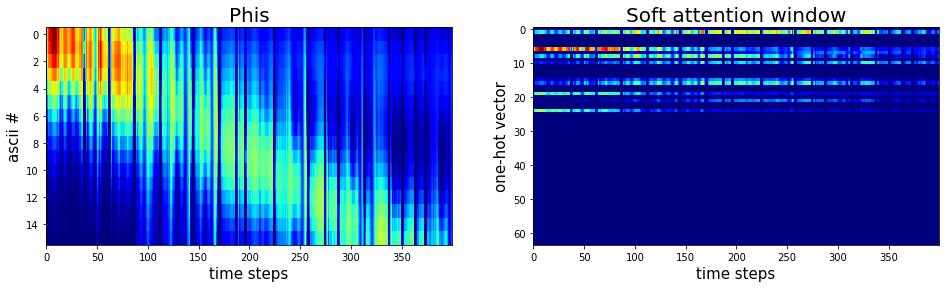

Epoch :  6  - step  410 / 548  - loss  104.53897857666016  in  12.428616285324097
Epoch :  6  - step  420 / 548  - loss  41.93141555786133  in  12.00653886795044
Epoch :  6  - step  430 / 548  - loss  51.2174072265625  in  12.154555797576904
Epoch :  6  - step  440 / 548  - loss  133.6432342529297  in  10.952919721603394
Epoch :  6  - step  450 / 548  - loss  160.37905883789062  in  10.658265113830566
Epoch :  6  - step  460 / 548  - loss  21.16019630432129  in  10.961113452911377
Epoch :  6  - step  470 / 548  - loss  -0.30041906237602234  in  11.350052118301392
Epoch :  6  - step  480 / 548  - loss  61.62136459350586  in  12.762739658355713
Epoch :  6  - step  490 / 548  - loss  12.247177124023438  in  12.460701942443848
Epoch :  6  - step  500 / 548  - loss  36.0236701965332  in  12.1243257522583


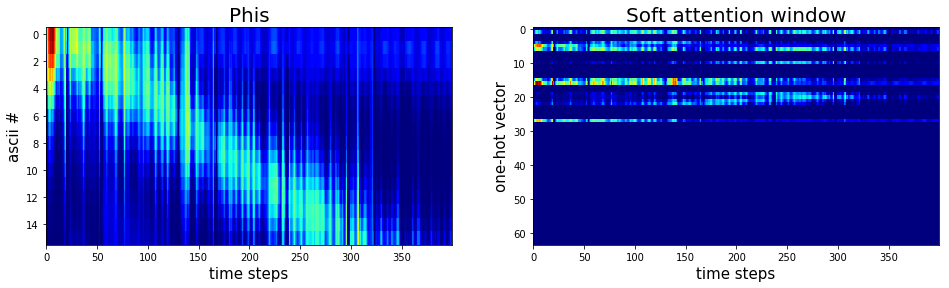

Epoch :  6  - step  510 / 548  - loss  -70.90803527832031  in  11.6904296875
Epoch :  6  - step  520 / 548  - loss  -83.19940948486328  in  10.805133819580078
Epoch :  6  - step  530 / 548  - loss  -21.619775772094727  in  11.606079816818237
Epoch :  6  - step  540 / 548  - loss  6.999965190887451  in  11.715513467788696
Generating sequence ...


FloatProgress(value=0.0, max=400.0)

(401, 3)


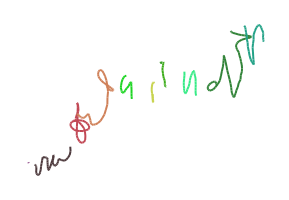

pointer reset
Epoch :  7  - step  0 / 548  - loss  13.580862998962402  in  134.95645761489868


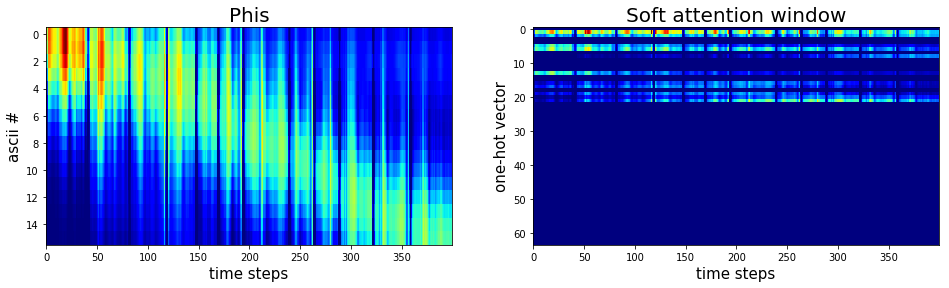

Epoch :  7  - step  10 / 548  - loss  34.886192321777344  in  11.65919280052185


KeyboardInterrupt: 

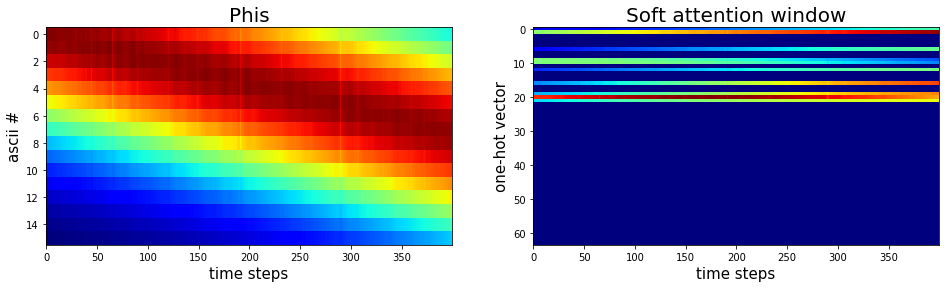

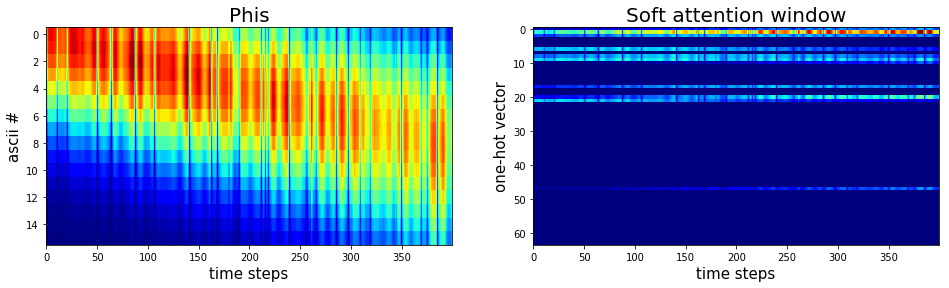

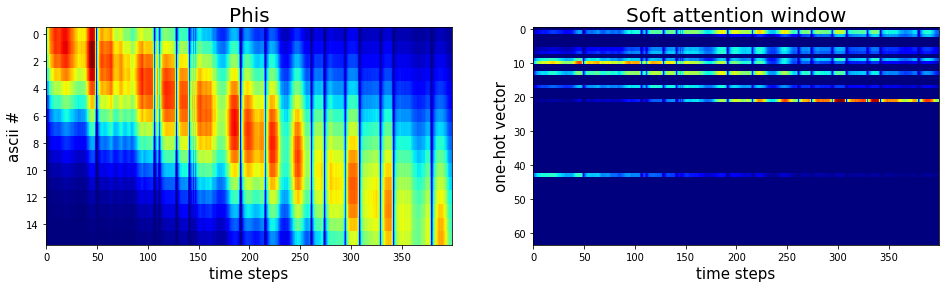

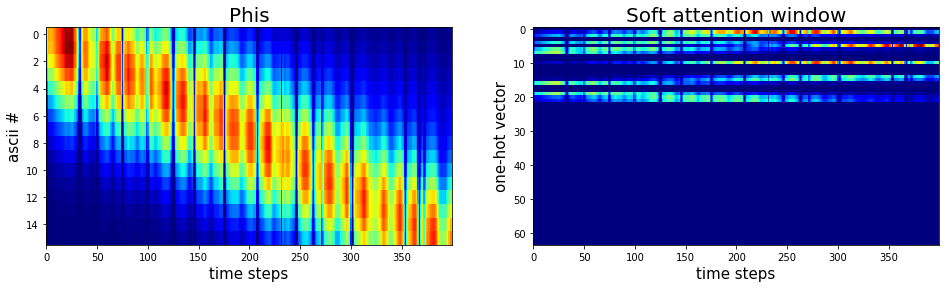

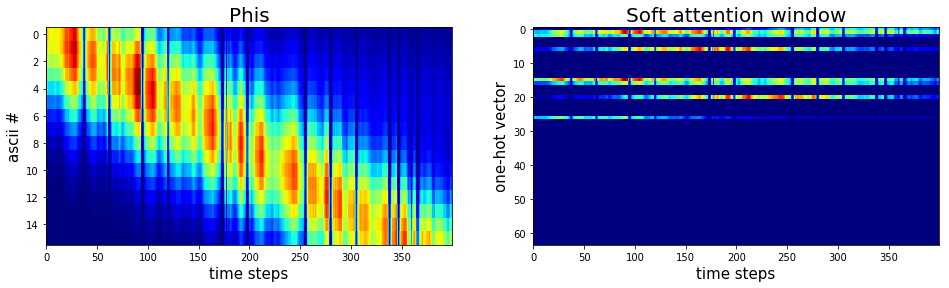

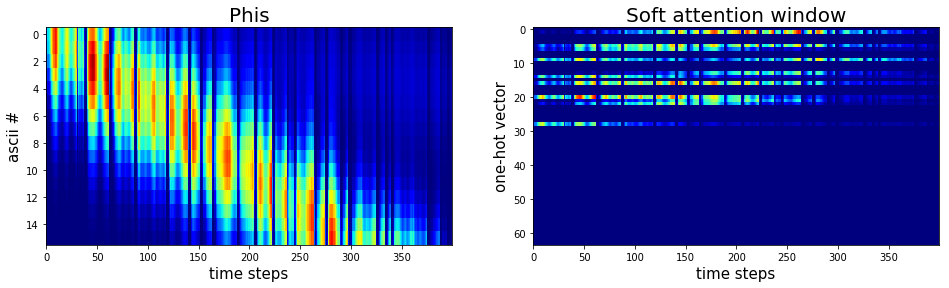

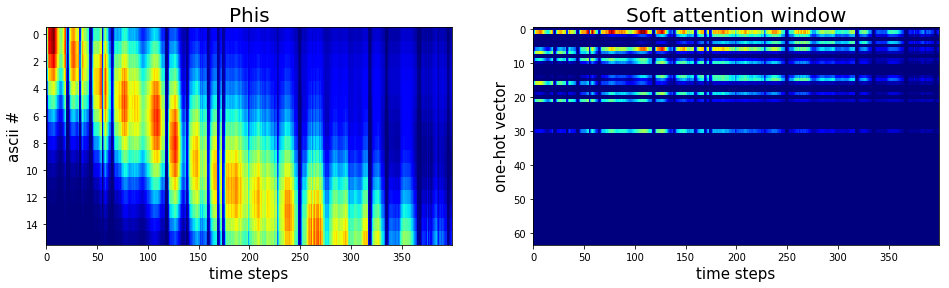

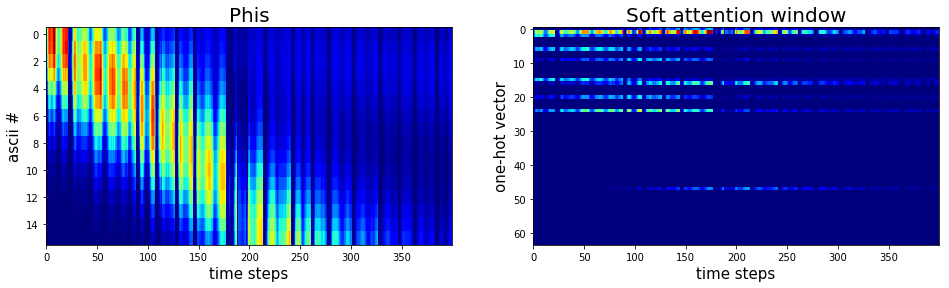

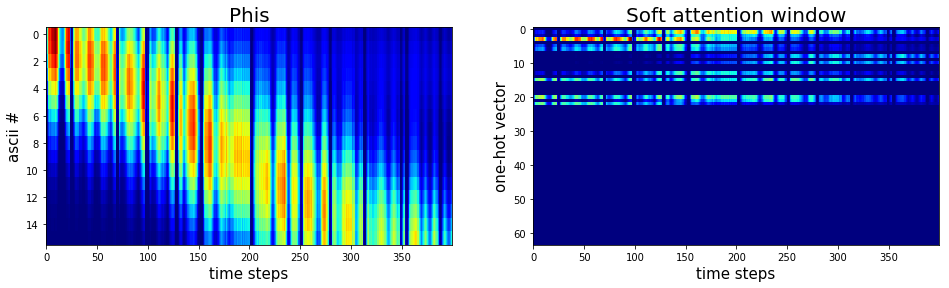

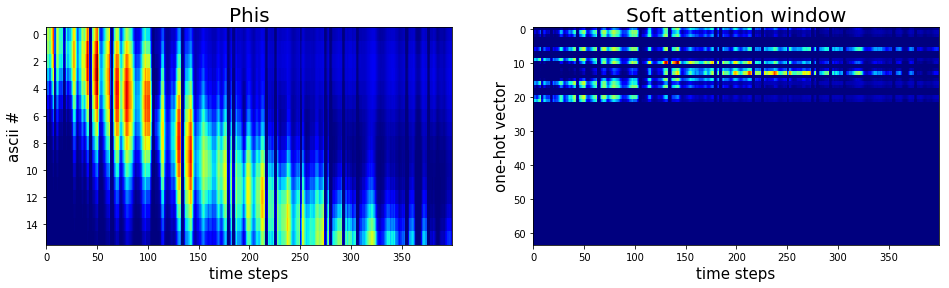

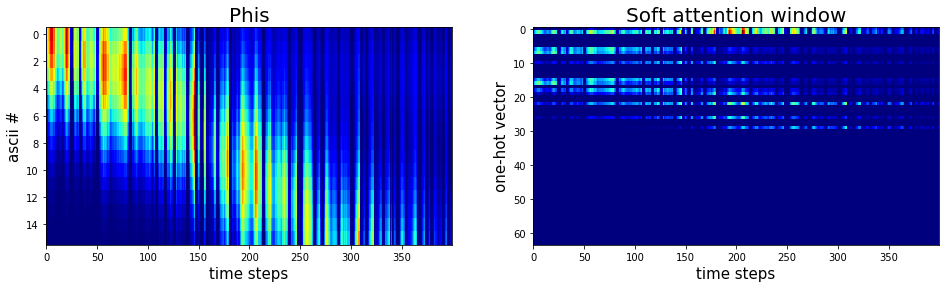

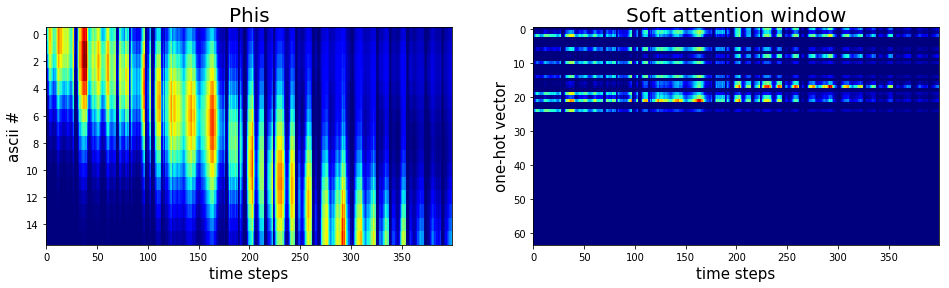

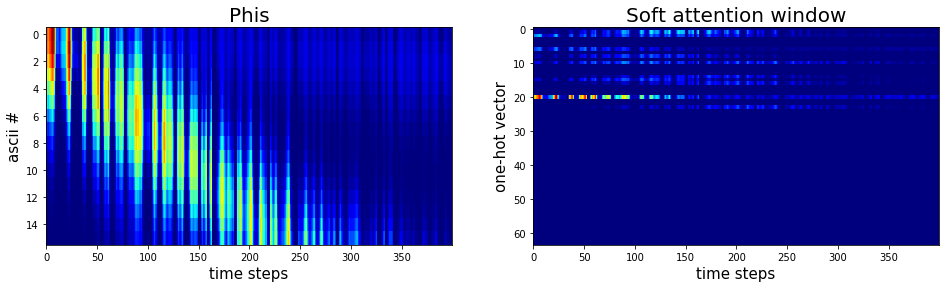

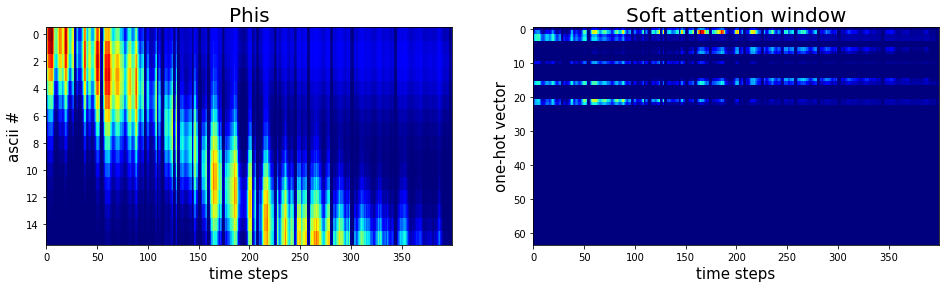

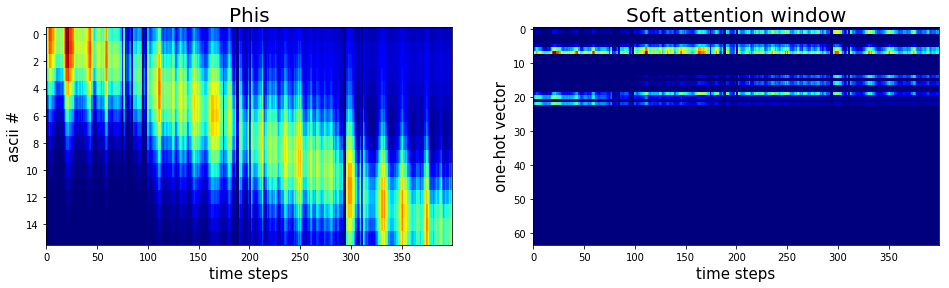

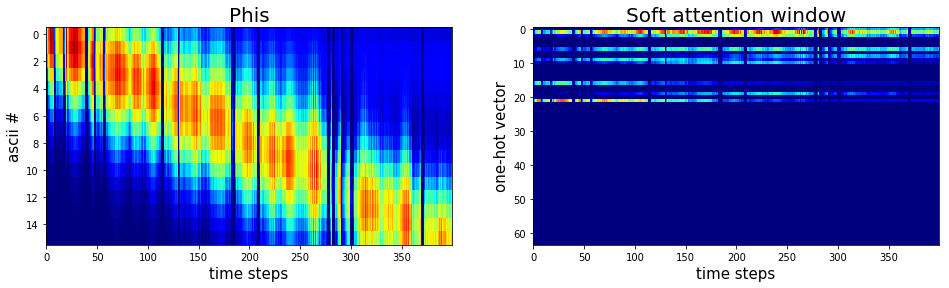

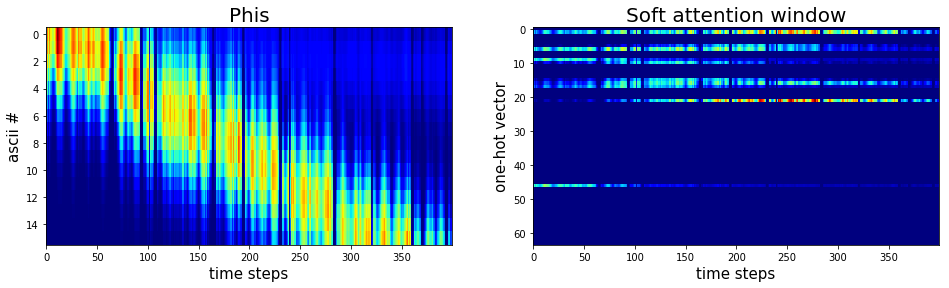

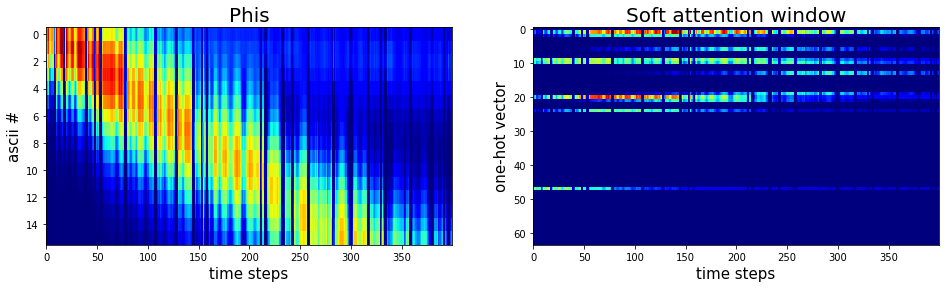

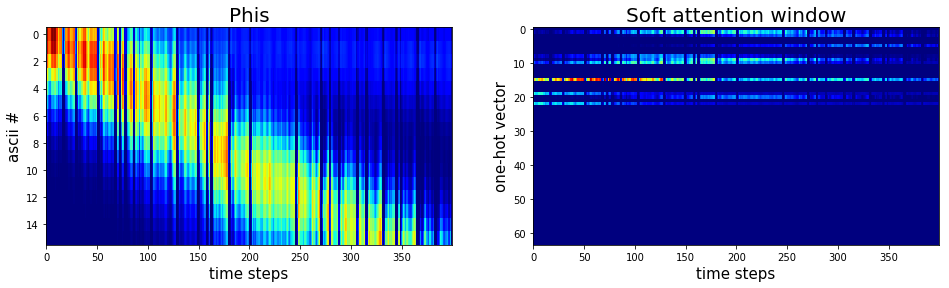

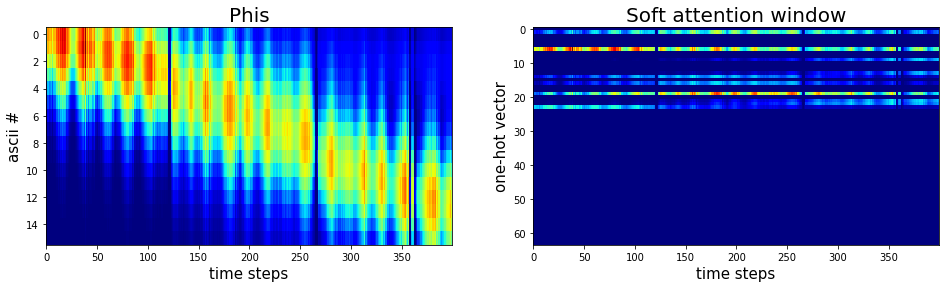

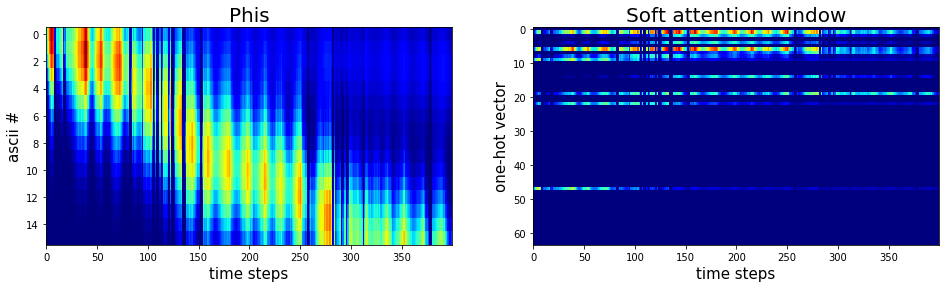

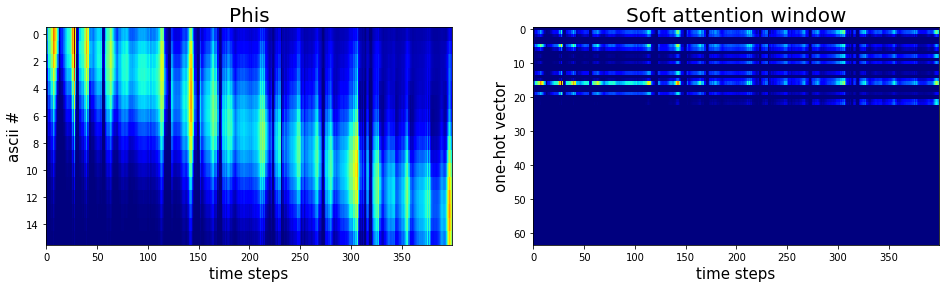

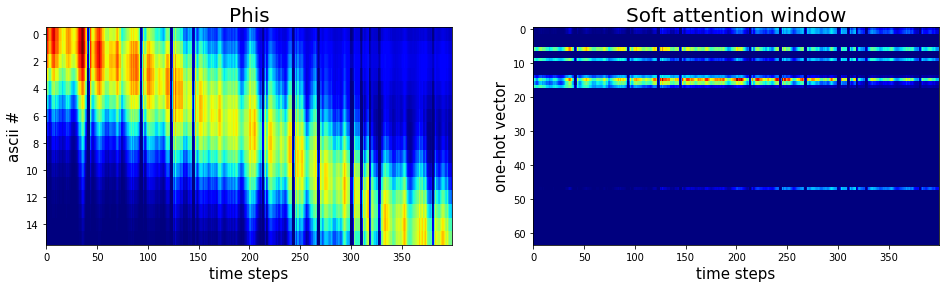

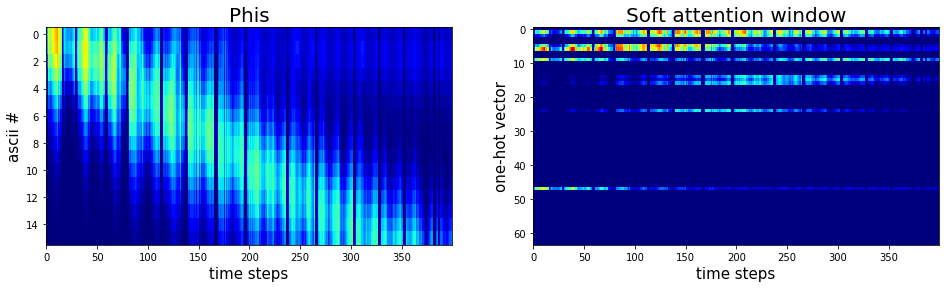

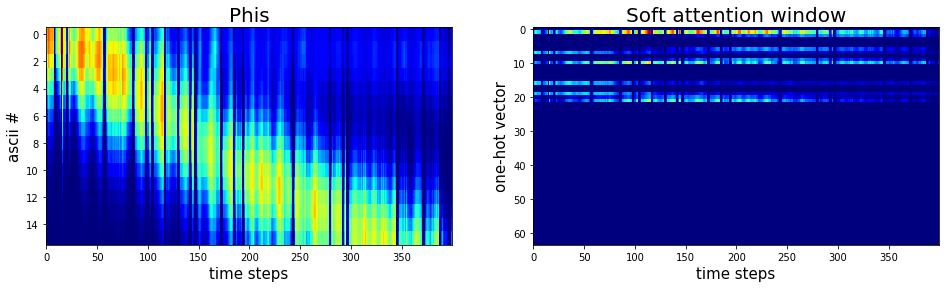

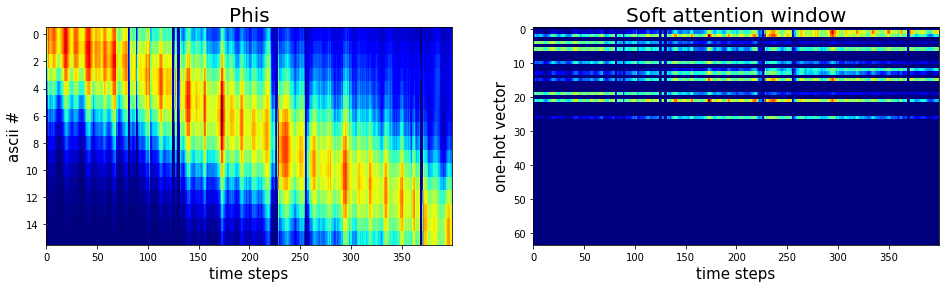

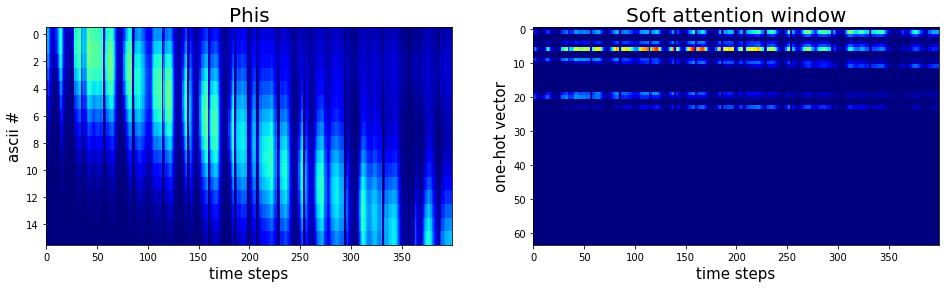

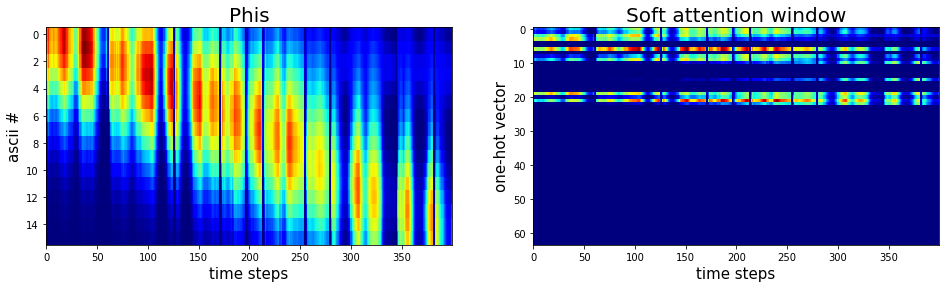

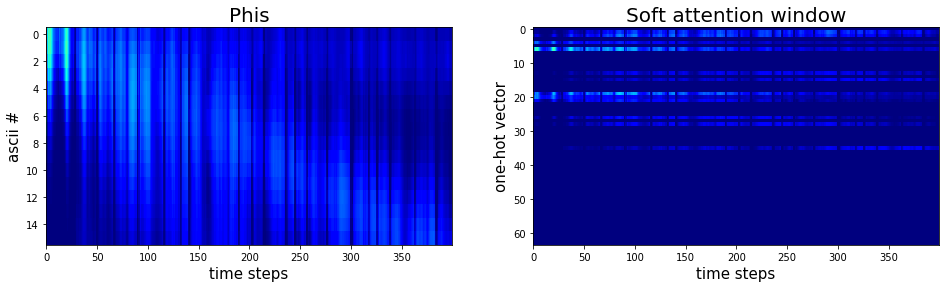

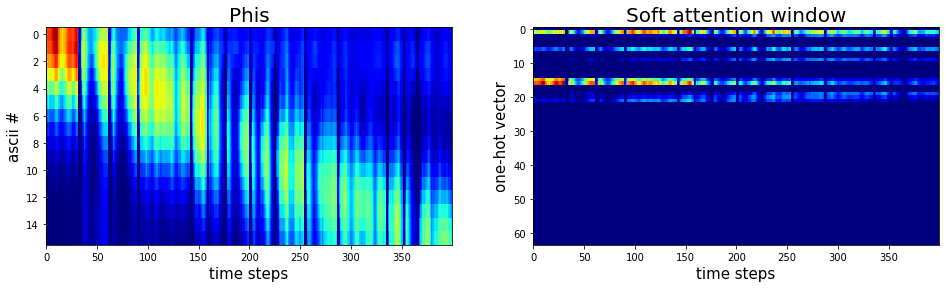

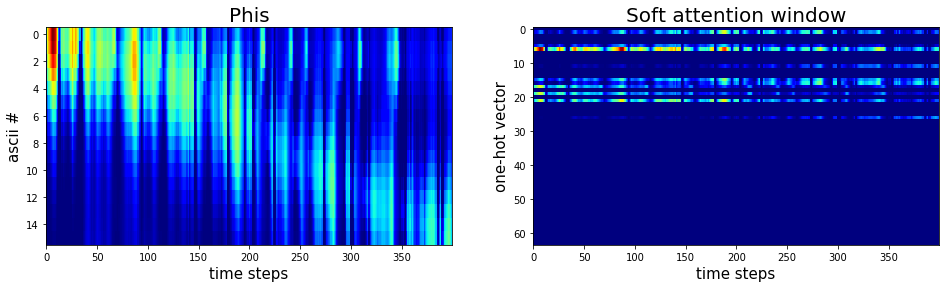

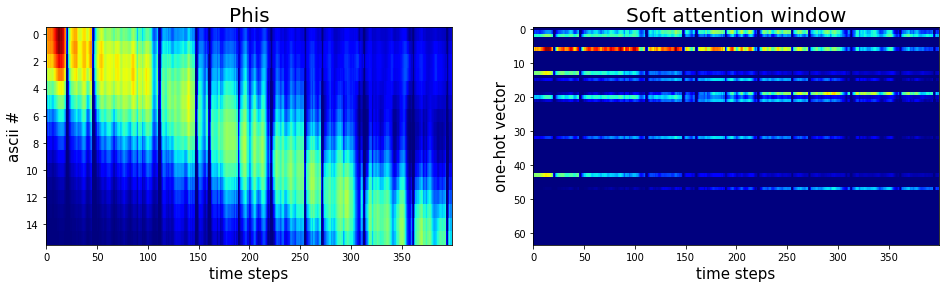

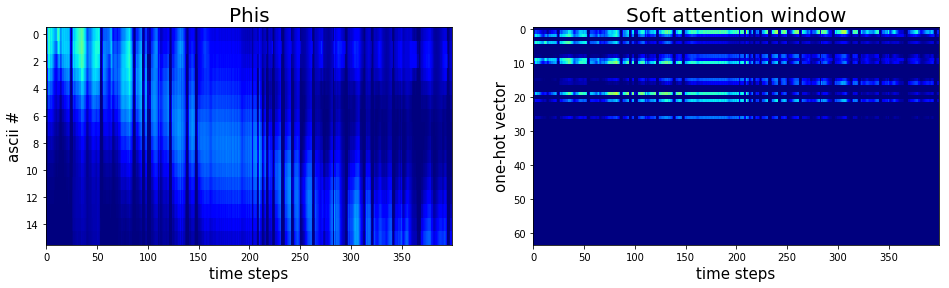

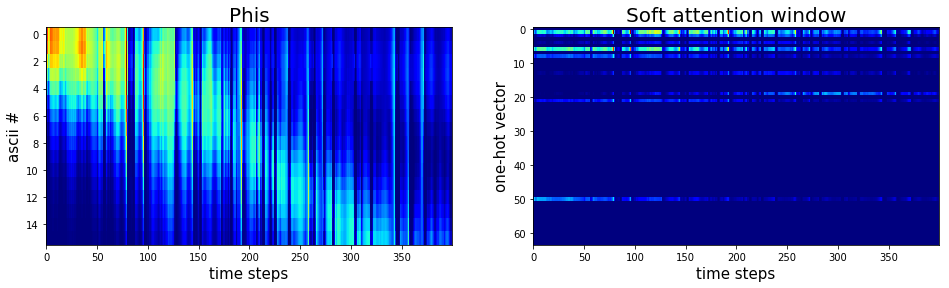

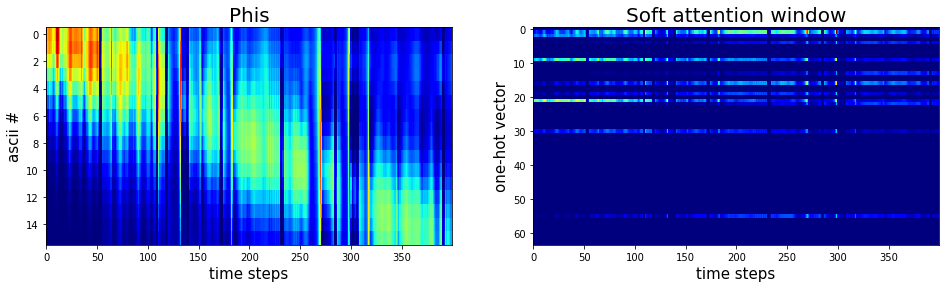

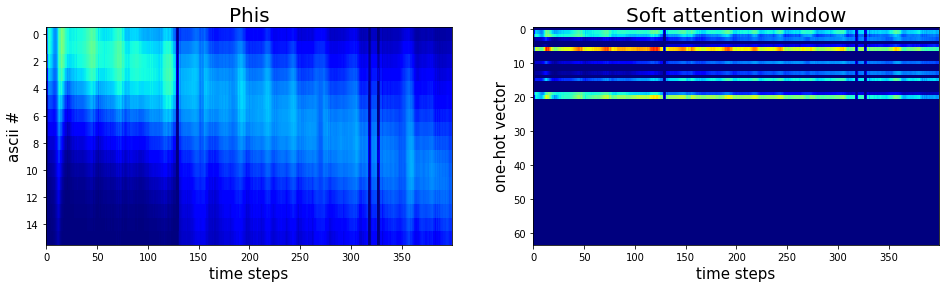

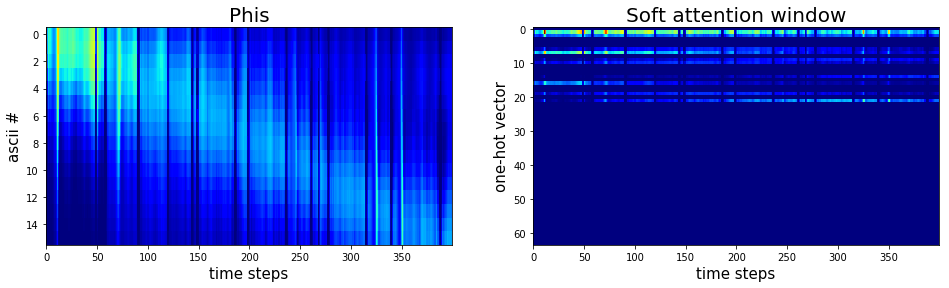

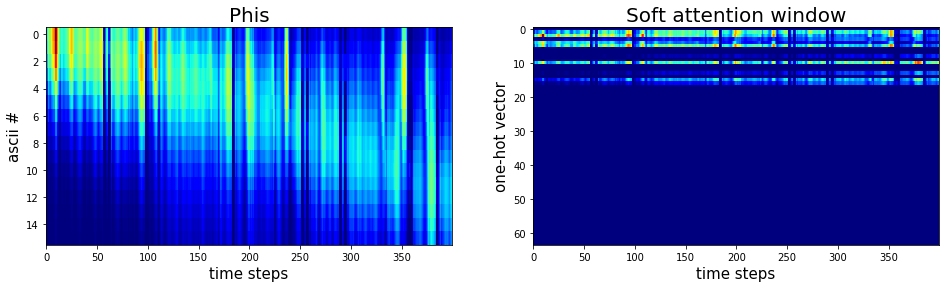

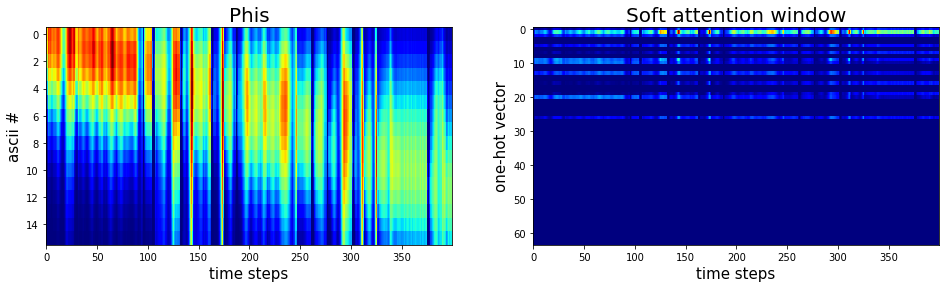

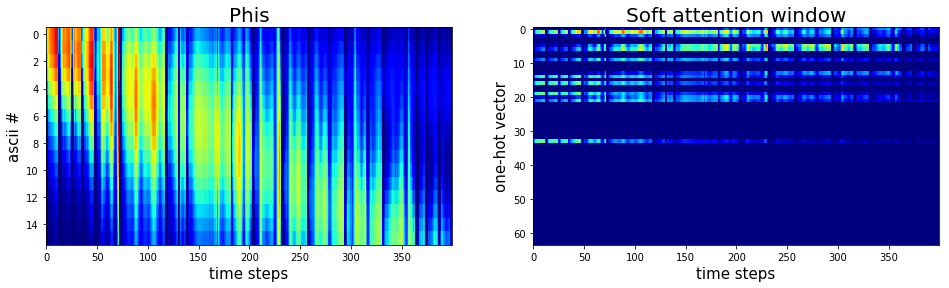

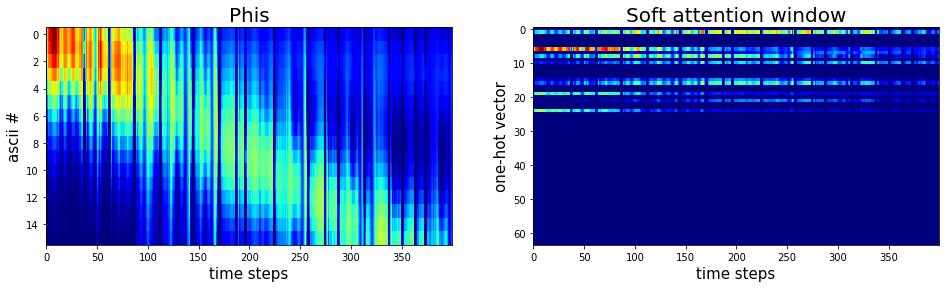

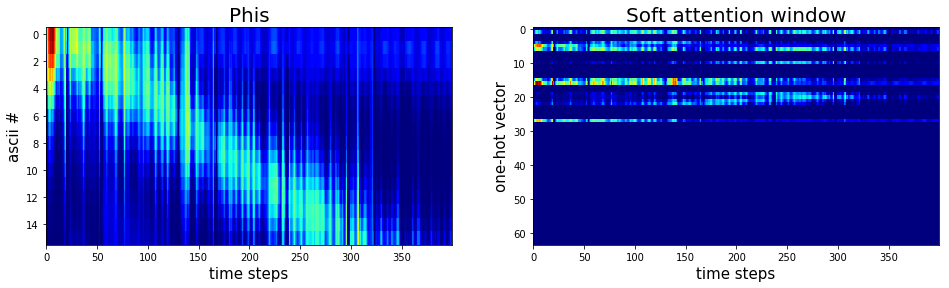

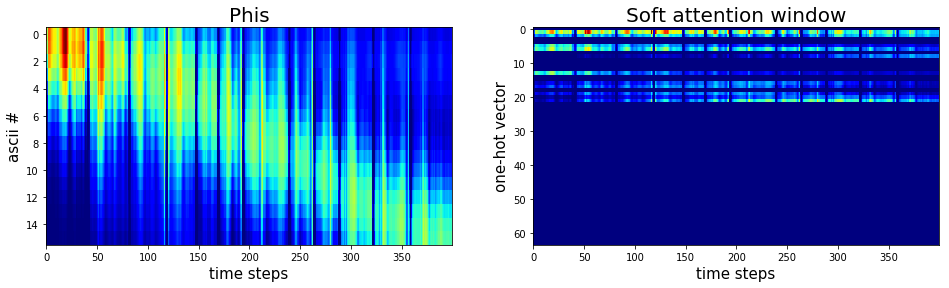

In [9]:
torch.cuda.empty_cache()
model = HandwritingSynthesisModel(hidden_size, n_gaussians, Kmixtures, dropout)

model = train_network(model, True)



## Test cell

In [ ]:
'''
torch.cuda.empty_cache()

modelTest = HandwritingSynthesisModel(hidden_size, n_gaussians, Kmixtures, dropout)

data_loader = DataLoader(n_batch, sequence_length, 20, U_items=U_items) # 20 = datascale
x, y, s, c = data_loader.next_batch()
x = np.float32(np.array(x)) # -> (n_batch, sequence_length, 3)
y = np.float32(np.array(y)) # -> (n_batch, sequence_length, 3)
c = np.float32(np.array(c))

x = torch.from_numpy(x).permute(1, 0, 2) # torch.Size([sequence_length, n_batch, 3])
y = torch.from_numpy(y).permute(1, 0, 2) # torch.Size([sequence_length, n_batch, 3])
c = torch.from_numpy(c) # torch.Size(n_batch, U_items, len(alphabet))

if use_cuda:
    modelTest = modelTest.cuda()
    x = x.cuda()
    y = y.cuda()
    c = c.cuda()

es, pis, mu1s, mu2s, sigma1s, sigma2s, rhos, Phis, Ws = modelTest.forward(x, c)


Pr = gaussianMixture(y, pis, mu1s, mu2s, sigma1s, sigma2s, rhos)
loss = loss_fn(Pr,y, es)

test = one_hot("Will it ever work ?")

x0 = torch.Tensor([0,0,1]).view(1,1,3)
c0 = np.float32(one_hot("Laurent estun PD"))
c0 = torch.from_numpy(c0) 
c0 = torch.unsqueeze(c0, 0) # torch.Size(n_batch, U_items, len(alphabet))

if use_cuda:
    x0 = x0.cuda()

sequence = model.generate_sequence(x0, c0)
print(sequence.shape)
draw_strokes_random_color(sequence, factor=0.5)
'''